In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Configurações
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print("Bibliotecas carregadas com sucesso!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {len(tf.config.list_physical_devices('GPU')) > 0}")

Bibliotecas carregadas com sucesso!
TensorFlow version: 2.18.0
GPU disponível: False


In [ ]:
def is_sp_municipality(codigo_ibge):
    """Verifica se o código IBGE pertence a um município de São Paulo"""
    return str(codigo_ibge).startswith('35')

In [ ]:
def load_pcf_data():
    """Carrega todos os arquivos CSV do Programa Criança Feliz"""

    # Dicionário para armazenar os dataframes
    dfs = {}

    # Lista de arquivos e suas colunas esperadas
    files_info = {
        'crianca2018.csv': {
            'year': 2018,
            'cols': ['codigo_ibge', 'anomes_s', 'visitas_realizadas_criancas_pcf_i',
                    'visitas_realizadas_gestantes_pcf_i', 'total_visitas_realizadas_pcf_i']
        },
        'crianca2019.csv': {
            'year': 2019,
            'cols': ['codigo_ibge', 'anomes_s', 'visitas_realizadas_criancas_pcf_i',
                    'visitas_realizadas_gestantes_pcf_i', 'total_visitas_realizadas_pcf_i']
        },
        'crianca2020.csv': {
            'year': 2020,
            'cols': ['codigo_ibge', 'anomes_s', 'visitas_realizadas_criancas_pcf_i',
                    'visitas_realizadas_gestantes_pcf_i', 'total_visitas_realizadas_pcf_i']
        },
        'crianca2021.csv': {
            'year': 2021,
            'cols': ['codigo_ibge', 'anomes_s', 'qtd_criancas_visitadas_pcf_i',
                    'qtd_gestantes_visitadas_pcf_i', 'total_pessoas_visitadas_pcf_i']
        },
        'crianca2022.csv': {
            'year': 2022,
            'cols': ['codigo_ibge', 'anomes_s', 'qtd_criancas_visitadas_pcf_i',
                    'qtd_gestantes_visitadas_pcf_i', 'total_pessoas_visitadas_pcf_i']
        }
    }

    for filename, info in files_info.items():
        try:
            df = pd.read_csv(filename)

            # Padronizar nomes de colunas
            if 'qtd_criancas_visitadas_pcf_i' in df.columns:
                df = df.rename(columns={
                    'qtd_criancas_visitadas_pcf_i': 'visitas_criancas',
                    'qtd_gestantes_visitadas_pcf_i': 'visitas_gestantes',
                    'total_pessoas_visitadas_pcf_i': 'total_visitas'
                })
            else:
                df = df.rename(columns={
                    'visitas_realizadas_criancas_pcf_i': 'visitas_criancas',
                    'visitas_realizadas_gestantes_pcf_i': 'visitas_gestantes',
                    'total_visitas_realizadas_pcf_i': 'total_visitas'
                })

            dfs[info['year']] = df
            print(f"✓ Carregado {filename}: {len(df)} registros")

        except Exception as e:
            print(f"✗ Erro ao carregar {filename}: {str(e)}")

    df_combined = pd.concat(dfs.values(), ignore_index=True)

    df_combined['ano'] = df_combined['anomes_s'].astype(str).str[:4].astype(int)
    df_combined['mes'] = df_combined['anomes_s'].astype(str).str[4:6].astype(int)
    df_combined['data'] = pd.to_datetime(df_combined['anomes_s'].astype(str), format='%Y%m')

    return df_combined


In [ ]:
visitas_df = load_pcf_data()

✓ Carregado crianca2018.csv: 25292 registros
✓ Carregado crianca2019.csv: 29311 registros
✓ Carregado crianca2020.csv: 30250 registros
✓ Carregado crianca2021.csv: 31725 registros
✓ Carregado crianca2022.csv: 16581 registros


In [ ]:
visitas_df = visitas_df[visitas_df['codigo_ibge'].apply(is_sp_municipality)]

In [ ]:
print(f"Total de registros de visitas em SP: {len(visitas_df)}")

Total de registros de visitas em SP: 8235


In [ ]:
visitas_df

,codigo_ibge,anomes_s,visitas_criancas,visitas_gestantes,total_visitas,ano,mes,data
1509,350030,201801,39,7.0,46,2018,1,2018-01-01
1510,350070,201801,349,6.0,355,2018,1,2018-01-01
1511,350130,201801,236,5.0,241,2018,1,2018-01-01
1512,350170,201801,213,16.0,229,2018,1,2018-01-01
1513,350190,201801,116,1.0,117,2018,1,2018-01-01
...,...,...,...,...,...,...,...,...
132845,355640,202201,159,NaN,159,2022,1,2022-01-01
132846,355650,202201,34,1.0,35,2022,1,2022-01-01
132847,355660,202201,95,14.0,109,2022,1,2022-01-01
132848,355680,202201,59,9.0,68,2022,1,2022-01-01


In [ ]:
# prompt: Usando o DataFrame visitas_df: quanto foi a taxa de queda de crianças visitadas apos o ano de 2020, comparando com o ano de 2018 a 2020

# Convert 'anomes_s' to string to extract the year
visitas_df['ano_str'] = visitas_df['anomes_s'].astype(str)
# Extract the year from the string
visitas_df['ano'] = visitas_df['ano_str'].str[:4].astype(int)

# Calculate the total visits for children between 2018 and 2020
total_visitas_2018_2020 = visitas_df[(visitas_df['ano'] >= 2018) & (visitas_df['ano'] <= 2020)]['visitas_criancas'].sum()

# Calculate the total visits for children after 2020
total_visitas_after_2020 = visitas_df[visitas_df['ano'] > 2020]['visitas_criancas'].sum()

# Calculate the average number of visits per year between 2018 and 2020
average_visitas_2018_2020 = total_visitas_2018_2020 / 3

# Calculate the number of years after 2020 in the dataset
num_years_after_2020 = visitas_df[visitas_df['ano'] > 2020]['ano'].nunique()

# Calculate the average number of visits per year after 2020
average_visitas_after_2020 = total_visitas_after_2020 / num_years_after_2020

# Calculate the percentage change (queda)
queda_percentual = ((average_visitas_after_2020 - average_visitas_2018_2020) / average_visitas_2018_2020) * 100

# Print the result
print(f"A taxa de queda média anual de visitas de crianças após 2020, comparada com a média anual de 2018 a 2020, foi de: {queda_percentual:.2f}%")

A taxa de queda média anual de visitas de crianças após 2020, comparada com a média anual de 2018 a 2020, foi de: -64.06%


In [ ]:
# Ensure codigo_ibge columns are of the same type (e.g., string)
visitas_df['codigo_ibge'] = visitas_df['codigo_ibge'].astype(str)
elegibilidade_df['codigo_ibge'] = elegibilidade_df['codigo_ibge'].astype(str)

# Select only the necessary columns from elegibilidade_df
elegibilidade_subset = elegibilidade_df[['codigo_ibge', 'municipios_adesao_pcf_i']].drop_duplicates(subset=['codigo_ibge'])

# Merge elegibilidade information into visitas_df based on codigo_ibge
visitas_df_with_adesao = visitas_df.merge(
    elegibilidade_subset,
    on='codigo_ibge',
    how='left' # Use left merge to keep all rows from visitas_df
)

# Fill NaN values in 'municipios_adesao_pcf_i' with 0 for municipalities not found in elegibilidade_df
visitas_df_with_adesao['municipios_adesao_pcf_i'] = visitas_df_with_adesao['municipios_adesao_pcf_i'].fillna(0).astype(int)

# Now visitas_df_with_adesao has the original visitas_df data plus the 'municipios_adesao_pcf_i' column

print("Coluna 'municipios_adesao_pcf_i' adicionada ao dataframe visitas_df.")
print("\nPrimeiras linhas do novo dataframe:")
print(visitas_df_with_adesao.head())

print("\nContagem de valores para 'municipios_adesao_pcf_i' no novo dataframe:")
print(visitas_df_with_adesao['municipios_adesao_pcf_i'].value_counts())
# You can now work with visitas_df_with_adesao

Coluna 'municipios_adesao_pcf_i' adicionada ao dataframe visitas_df.

Primeiras linhas do novo dataframe:
  codigo_ibge  anomes_s  visitas_criancas  visitas_gestantes  total_visitas  \
0      350030    201801                39                7.0             46   
1      350070    201801               349                6.0            355   
2      350130    201801               236                5.0            241   
3      350170    201801               213               16.0            229   
4      350190    201801               116                1.0            117   

    ano  mes       data  houve_visita_mes  teve_alguma_visita  \
0  2018    1 2018-01-01              True                True   
1  2018    1 2018-01-01              True                True   
2  2018    1 2018-01-01              True                True   
3  2018    1 2018-01-01              True                True   
4  2018    1 2018-01-01              True                True   

   municipios_adesao_pcf_i  

In [ ]:
visitas_df = visitas_df_with_adesao

In [ ]:
# Substituir todos os valores NaN no df_combinado por 0
visitas_df = visitas_df.fillna(0)

print("Valores NaN substituídos por 0 em df_combinado.")
print("\nVerificando a contagem de valores NaN após a substituição:")
print(visitas_df.isnull().sum())

Valores NaN substituídos por 0 em df_combinado.

Verificando a contagem de valores NaN após a substituição:
codigo_ibge                0
anomes_s                   0
visitas_criancas           0
visitas_gestantes          0
total_visitas              0
ano                        0
mes                        0
data                       0
houve_visita_mes           0
teve_alguma_visita         0
municipios_adesao_pcf_i    0
dtype: int64


In [ ]:
print("\nCarregando dados de elegibilidade e adesão...")
elegibilidade_df = pd.read_csv('municipio_elegivel.csv')
elegibilidade_df = elegibilidade_df[elegibilidade_df['codigo_ibge'].apply(is_sp_municipality)]


Carregando dados de elegibilidade e adesão...


In [ ]:
elegibilidade_df['municipios_adesao_pcf_i'] = elegibilidade_df['municipios_adesao_pcf_i'].fillna(0)

print(f"Total de registros de elegibilidade em SP: {len(elegibilidade_df)}")

Total de registros de elegibilidade em SP: 4942


In [ ]:
elegibilidade_df['municipios_adesao_pcf_i'] = elegibilidade_df['municipios_adesao_pcf_i'].astype(int)
elegibilidade_df['data'] = pd.to_datetime(elegibilidade_df['anomes_s'].astype(str), format='%Y%m')
elegibilidade_df

,codigo_ibge,anomes_s,municipios_elegiveis_pcf_i,municipios_adesao_pcf_i,data
2730,350030,201809,1,1,2018-09-01
2731,350070,201809,1,1,2018-09-01
2732,350100,201809,1,1,2018-09-01
2733,350115,201809,1,1,2018-09-01
2734,350130,201809,1,0,2018-09-01
...,...,...,...,...,...
52218,355660,201910,1,1,2019-10-01
52219,355670,201910,1,0,2019-10-01
52220,355700,201910,1,0,2019-10-01
52221,355710,201910,1,1,2019-10-01


In [ ]:
print("\nCarregando dados do IPDM...")
ipdm_df = pd.read_csv('arq_ipdm_painel_v2024.csv', encoding='cp1252', sep=';')

# Filtrar apenas municípios de SP
ipdm_df['codigo_ibge'] = ipdm_df['cod_ibge'].astype(str)
ipdm_df = ipdm_df[ipdm_df['codigo_ibge'].apply(is_sp_municipality)]


Carregando dados do IPDM...


In [ ]:
df = ipdm_df.copy()
# Function to convert comma decimal format to float
def convert_comma_decimal(value):
    """Convert comma decimal format (e.g., ',548') to float (e.g., 0.548)"""
    if pd.isna(value) or value.strip() == '':
        return np.nan
    try:
        # Remove any spaces and convert comma to decimal point
        clean_value = str(value).strip().replace(',', '0.')
        return float(clean_value)
    except:
        return np.nan

# Apply the conversion to Valor and Valor_Estado columns
df['Valor'] = df['Valor'].apply(convert_comma_decimal)

# Convert numeric columns
df['cod_ibge'] = pd.to_numeric(df['cod_ibge'])
df['Ano'] = pd.to_numeric(df['Ano'])

# Clean municipality names (remove extra spaces)
df['Municipio'] = df['Municipio'].str.strip()

# Display unique types to verify data structure
print("Unique values in 'Tipo' column:")
print(df['Tipo'].unique())
print("\nData overview:")
print(df.head())

# Create separate dataframes for IPDM general and individual indicators
df_ipdm = df[df['Tipo'] == 'IPDM'].copy()
df_riqueza = df[df['Indicador5'] == 'Indicador Riqueza'].copy()
df_longevidade = df[df['Indicador5'] == 'Indicador Longevidade'].copy()
df_escolaridade = df[df['Indicador5'] == 'Indicador Escolaridade'].copy()

print(f"\nData counts:")
print(f"IPDM rows: {len(df_ipdm)}")
print(f"Riqueza rows: {len(df_riqueza)}")
print(f"Longevidade rows: {len(df_longevidade)}")
print(f"Escolaridade rows: {len(df_escolaridade)}")

# Create the base dataframe with IPDM data
pivot_df = df_ipdm[['cod_ibge', 'Municipio', 'Ano', 'Valor']].copy()
pivot_df = pivot_df.rename(columns={
    'cod_ibge': 'codigo_ibge',
    'Municipio': 'municipio',
    'Ano': 'ano',
    'Valor': 'valor_ipdm'
})

# Merge with Riqueza data
riqueza_merge = df_riqueza[['cod_ibge', 'Ano', 'Valor']].rename(columns={
    'cod_ibge': 'codigo_ibge',
    'Ano': 'ano',
    'Valor': 'valor_riqueza'
})

pivot_df = pivot_df.merge(riqueza_merge, on=['codigo_ibge', 'ano'], how='left')

# Merge with Longevidade data
longevidade_merge = df_longevidade[['cod_ibge', 'Ano', 'Valor']].rename(columns={
    'cod_ibge': 'codigo_ibge',
    'Ano': 'ano',
    'Valor': 'valor_longevidade'
})

pivot_df = pivot_df.merge(longevidade_merge, on=['codigo_ibge', 'ano'], how='left')

# Merge with Escolaridade data
escolaridade_merge = df_escolaridade[['cod_ibge', 'Ano', 'Valor']].rename(columns={
    'cod_ibge': 'codigo_ibge',
    'Ano': 'ano',
    'Valor': 'valor_escolaridade'
})

pivot_df = pivot_df.merge(escolaridade_merge, on=['codigo_ibge', 'ano'], how='left')

# Sort the final dataframe
pivot_df = pivot_df.sort_values(['codigo_ibge', 'ano'])

# Display the final structure
print(f"\nFinal pivot table shape: {pivot_df.shape}")
print("\nColumn names:")
print(pivot_df.columns.tolist())

print("\nFirst 10 rows of the pivot table:")
print(pivot_df.head(10))

# Check for missing values
print("\nMissing values per column:")
print(pivot_df.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
print(pivot_df.describe())

# Save the pivot table to a new CSV file (optional)
# pivot_df.to_csv('ipdm_pivot_table.csv', index=False)
# print("\nPivot table saved as 'ipdm_pivot_table.csv'")

# Verify data integrity by checking a sample municipality
sample_municipio = pivot_df.iloc[0]['municipio']
sample_data = pivot_df[pivot_df['municipio'] == sample_municipio]
print(f"\nSample data for {sample_municipio}:")
print(sample_data)

Unique values in 'Tipo' column:
['IPDM' 'Riqueza' 'Longevidade' 'Escolaridade']

Data overview:
   cod_ibge   Municipio  Valor   Ano  Tipo Valor_Estado Indicador1 Indicador2  \
0   3500105  Adamantina  0.548  2014  IPDM         ,535                         
1   3500105  Adamantina  0.554  2016  IPDM         ,555                         
2   3500105  Adamantina  0.560  2018  IPDM         ,578                         
3   3500105  Adamantina  0.594  2020  IPDM         ,585                         
4   3500105  Adamantina  0.565  2022  IPDM         ,565                         

  Indicador3 Indicador4 Indicador5 codigo_ibge  
0                                      3500105  
1                                      3500105  
2                                      3500105  
3                                      3500105  
4                                      3500105  

Data counts:
IPDM rows: 3225
Riqueza rows: 3225
Longevidade rows: 3225
Escolaridade rows: 3225

Final pivot table shape: (

In [ ]:
pivot_df

,codigo_ibge,municipio,ano,valor_ipdm,valor_riqueza,valor_longevidade,valor_escolaridade
0,3500105,Adamantina,2014,0.548,0.365,0.770,0.510
1,3500105,Adamantina,2016,0.554,0.365,0.710,0.587
2,3500105,Adamantina,2018,0.560,0.382,0.686,0.612
3,3500105,Adamantina,2020,0.594,0.378,0.779,0.625
4,3500105,Adamantina,2022,0.565,0.359,0.742,0.594
...,...,...,...,...,...,...,...
3220,3557303,Estiva Gerbi,2014,0.484,0.335,0.661,0.457
3221,3557303,Estiva Gerbi,2016,0.542,0.315,0.779,0.533
3222,3557303,Estiva Gerbi,2018,0.562,0.354,0.799,0.533
3223,3557303,Estiva Gerbi,2020,0.547,0.349,0.771,0.521


In [ ]:
# Filtrar os anos que você quer replicar
df_2018 = pivot_df[pivot_df['ano'] == 2018].copy()
df_2020 = pivot_df[pivot_df['ano'] == 2020].copy()

# Criar cópias e mudar o ano
df_2019_replicado = df_2018.copy()
df_2019_replicado['ano'] = 2019

df_2021_replicado = df_2020.copy()
df_2021_replicado['ano'] = 2021

# Concatenar os dataframes originais e os replicados
pivot_df_expandido = pd.concat([
    pivot_df,
    df_2019_replicado,
    df_2021_replicado
])

# Ordenar por codigo_ibge e ano para uma melhor visualização
pivot_df_expandido = pivot_df_expandido.sort_values(['codigo_ibge', 'ano']).reset_index(drop=True)

print("DataFrame pivot_df expandido com anos replicados:")
print(pivot_df_expandido.head(15)) # Mostra os primeiros registros para verificar a duplicação
print(f"\nShape original: {pivot_df.shape}")
print(f"Shape expandido: {pivot_df_expandido.shape}")

# Atualizar o dataframe original se desejar
pivot_df_expandido

DataFrame pivot_df expandido com anos replicados:
    codigo_ibge   municipio   ano  valor_ipdm  valor_riqueza  \
0       3500105  Adamantina  2014       0.548          0.365   
1       3500105  Adamantina  2016       0.554          0.365   
2       3500105  Adamantina  2018       0.560          0.382   
3       3500105  Adamantina  2019       0.560          0.382   
4       3500105  Adamantina  2020       0.594          0.378   
5       3500105  Adamantina  2021       0.594          0.378   
6       3500105  Adamantina  2022       0.565          0.359   
7       3500204      Adolfo  2014       0.566          0.386   
8       3500204      Adolfo  2016       0.520          0.356   
9       3500204      Adolfo  2018       0.584          0.412   
10      3500204      Adolfo  2019       0.584          0.412   
11      3500204      Adolfo  2020       0.594          0.442   
12      3500204      Adolfo  2021       0.594          0.442   
13      3500204      Adolfo  2022       0.596         

,codigo_ibge,municipio,ano,valor_ipdm,valor_riqueza,valor_longevidade,valor_escolaridade
0,3500105,Adamantina,2014,0.548,0.365,0.770,0.510
1,3500105,Adamantina,2016,0.554,0.365,0.710,0.587
2,3500105,Adamantina,2018,0.560,0.382,0.686,0.612
3,3500105,Adamantina,2019,0.560,0.382,0.686,0.612
4,3500105,Adamantina,2020,0.594,0.378,0.779,0.625
...,...,...,...,...,...,...,...
4510,3557303,Estiva Gerbi,2018,0.562,0.354,0.799,0.533
4511,3557303,Estiva Gerbi,2019,0.562,0.354,0.799,0.533
4512,3557303,Estiva Gerbi,2020,0.547,0.349,0.771,0.521
4513,3557303,Estiva Gerbi,2021,0.547,0.349,0.771,0.521


In [ ]:
# Filtrar o dataframe para manter apenas os anos de 2018 a 2022
pivot_df_filtrado = pivot_df_expandido[(pivot_df_expandido['ano'] >= 2018) & (pivot_df_expandido['ano'] <= 2022)].copy()

# Atualizar o dataframe original se desejar (opcional, mas parece ser a intenção)
pivot_df_expandido = pivot_df_filtrado

print("DataFrame pivot_df_expandido filtrado para anos 2018 a 2022:")
print(pivot_df_expandido.head())
print(f"\nShape após filtro: {pivot_df_expandido.shape}")
print("\nAnos presentes no dataframe filtrado:")
print(pivot_df_expandido['ano'].unique())

DataFrame pivot_df_expandido filtrado para anos 2018 a 2022:
   codigo_ibge   municipio   ano  valor_ipdm  valor_riqueza  \
2      3500105  Adamantina  2018       0.560          0.382   
3      3500105  Adamantina  2019       0.560          0.382   
4      3500105  Adamantina  2020       0.594          0.378   
5      3500105  Adamantina  2021       0.594          0.378   
6      3500105  Adamantina  2022       0.565          0.359   

   valor_longevidade  valor_escolaridade  
2              0.686               0.612  
3              0.686               0.612  
4              0.779               0.625  
5              0.779               0.625  
6              0.742               0.594  

Shape após filtro: (3225, 7)

Anos presentes no dataframe filtrado:
[2018 2019 2020 2021 2022]


In [ ]:
ipdm_cols = ['codigo_ibge', 'municipio', 'ano', 'valor_ipdm', 'valor_riqueza', 'valor_longevidade', 'valor_escolaridade']
ipdm_df = pivot_df_expandido[ipdm_cols]
ipdm_df.columns = ['codigo_ibge', 'municipio', 'ano', 'ipdm_geral', 'ipdm_riqueza', 'ipdm_longevidade', 'ipdm_educacao']


print(f"Total de registros IPDM em SP: {len(ipdm_df)}")

Total de registros IPDM em SP: 3225


In [ ]:
ipdm_df

,codigo_ibge,municipio,ano,ipdm_geral,ipdm_riqueza,ipdm_longevidade,ipdm_educacao
2,3500105,Adamantina,2018,0.560,0.382,0.686,0.612
3,3500105,Adamantina,2019,0.560,0.382,0.686,0.612
4,3500105,Adamantina,2020,0.594,0.378,0.779,0.625
5,3500105,Adamantina,2021,0.594,0.378,0.779,0.625
6,3500105,Adamantina,2022,0.565,0.359,0.742,0.594
...,...,...,...,...,...,...,...
4510,3557303,Estiva Gerbi,2018,0.562,0.354,0.799,0.533
4511,3557303,Estiva Gerbi,2019,0.562,0.354,0.799,0.533
4512,3557303,Estiva Gerbi,2020,0.547,0.349,0.771,0.521
4513,3557303,Estiva Gerbi,2021,0.547,0.349,0.771,0.521


In [ ]:
print("\nCarregando dados do censo SP 2022...")
censo_sp = pd.read_csv('censo_sp_2022.csv')

# Calcular população infantil total (0-9 anos)
idade_cols = ['Menos de 1 ano', '1 ano', '2 anos', '3 anos', '4 anos',
              '5 anos', '6 anos', '7 anos', '8 anos', '9 anos']
censo_sp['populacao_infantil'] = censo_sp[idade_cols].sum(axis=1)
censo_sp = censo_sp.rename(columns={'Codigo': 'codigo_ibge', 'Cidade': 'municipio',
                                    'Menos de 1 ano': '0ano',
                                    '1 ano': '1ano',
                                    '2 anos': '2anos',
                                    '3 anos': '3anos',
                                    '4 anos': '4anos',
                                    '5 anos': '5anos',
                                    '6 anos': '6anos',
                                    '7 anos': '7anos',
                                    '8 anos': '8anos',
                                    '9 anos': '9anos'})
censo_sp['codigo_ibge'] = censo_sp['codigo_ibge'].astype(str)

print(f"Total de municípios no censo SP: {len(censo_sp)}")


Carregando dados do censo SP 2022...
Total de municípios no censo SP: 646


In [ ]:

censo_sp = censo_sp.iloc[:-1].copy()
censo_sp

,codigo_ibge,municipio,0ano,1ano,2anos,3anos,4anos,5anos,6anos,7anos,8anos,9anos,populacao_infantil
0,3500105,Adamantina (SP),358.0,342.0,354.0,387.0,322.0,318.0,369.0,345.0,356.0,351.0,3502.0
1,3500204,Adolfo (SP),54.0,52.0,44.0,43.0,49.0,47.0,55.0,76.0,55.0,58.0,533.0
2,3500303,Aguaí (SP),361.0,373.0,385.0,420.0,431.0,440.0,385.0,394.0,399.0,443.0,4031.0
3,3500402,Águas da Prata (SP),68.0,71.0,64.0,64.0,76.0,90.0,81.0,75.0,102.0,74.0,765.0
4,3500501,Águas de Lindóia (SP),142.0,136.0,180.0,185.0,160.0,196.0,201.0,177.0,189.0,180.0,1746.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,3557006,Votorantim (SP),1481.0,1386.0,1594.0,1588.0,1768.0,1614.0,1625.0,1757.0,1729.0,1702.0,16244.0
641,3557105,Votuporanga (SP),990.0,1049.0,1007.0,1150.0,1118.0,1057.0,1119.0,1111.0,1088.0,1105.0,10794.0
642,3557154,Zacarias (SP),15.0,33.0,31.0,32.0,31.0,32.0,31.0,44.0,22.0,39.0,310.0
643,3557204,Chavantes (SP),144.0,142.0,134.0,147.0,151.0,172.0,160.0,173.0,183.0,141.0,1547.0


In [ ]:
censo_replicado_list = []

censo_2022 = censo_sp.copy()
censo_2022['ano'] = 2022
censo_replicado_list.append(censo_2022)

anos_anteriores = [2018, 2019, 2020, 2021]

for ano in anos_anteriores:
    censo_ano = censo_sp.copy()
    censo_ano['ano'] = ano
    censo_replicado_list.append(censo_ano)

censo_expandido_df = pd.concat(censo_replicado_list, ignore_index=True)
censo_expandido_df = censo_expandido_df.sort_values(['codigo_ibge', 'ano']).reset_index(drop=True)
censo_sp = censo_expandido_df

print("Dados do censo de 2022 replicados para os anos de 2018 a 2021.")
print(f"\nNovo shape de censo_sp: {censo_sp.shape}")
print("\nAnos presentes no dataframe censo_sp:")
print(censo_sp['ano'].unique())
print("\nPrimeiras linhas do censo_sp expandido:")
print(censo_sp.head(10))
censo_sp

Dados do censo de 2022 replicados para os anos de 2018 a 2021.

Novo shape de censo_sp: (3225, 14)

Anos presentes no dataframe censo_sp:
[2018 2019 2020 2021 2022]

Primeiras linhas do censo_sp expandido:
  codigo_ibge        municipio   0ano   1ano  2anos  3anos  4anos  5anos  \
0     3500105  Adamantina (SP)  358.0  342.0  354.0  387.0  322.0  318.0   
1     3500105  Adamantina (SP)  358.0  342.0  354.0  387.0  322.0  318.0   
2     3500105  Adamantina (SP)  358.0  342.0  354.0  387.0  322.0  318.0   
3     3500105  Adamantina (SP)  358.0  342.0  354.0  387.0  322.0  318.0   
4     3500105  Adamantina (SP)  358.0  342.0  354.0  387.0  322.0  318.0   
5     3500204      Adolfo (SP)   54.0   52.0   44.0   43.0   49.0   47.0   
6     3500204      Adolfo (SP)   54.0   52.0   44.0   43.0   49.0   47.0   
7     3500204      Adolfo (SP)   54.0   52.0   44.0   43.0   49.0   47.0   
8     3500204      Adolfo (SP)   54.0   52.0   44.0   43.0   49.0   47.0   
9     3500204      Adolfo (SP)   5

,codigo_ibge,municipio,0ano,1ano,2anos,3anos,4anos,5anos,6anos,7anos,8anos,9anos,populacao_infantil,ano
0,3500105,Adamantina (SP),358.0,342.0,354.0,387.0,322.0,318.0,369.0,345.0,356.0,351.0,3502.0,2018
1,3500105,Adamantina (SP),358.0,342.0,354.0,387.0,322.0,318.0,369.0,345.0,356.0,351.0,3502.0,2019
2,3500105,Adamantina (SP),358.0,342.0,354.0,387.0,322.0,318.0,369.0,345.0,356.0,351.0,3502.0,2020
3,3500105,Adamantina (SP),358.0,342.0,354.0,387.0,322.0,318.0,369.0,345.0,356.0,351.0,3502.0,2021
4,3500105,Adamantina (SP),358.0,342.0,354.0,387.0,322.0,318.0,369.0,345.0,356.0,351.0,3502.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,3557303,Estiva Gerbi (SP),134.0,139.0,130.0,147.0,161.0,143.0,152.0,150.0,145.0,132.0,1433.0,2018
3221,3557303,Estiva Gerbi (SP),134.0,139.0,130.0,147.0,161.0,143.0,152.0,150.0,145.0,132.0,1433.0,2019
3222,3557303,Estiva Gerbi (SP),134.0,139.0,130.0,147.0,161.0,143.0,152.0,150.0,145.0,132.0,1433.0,2020
3223,3557303,Estiva Gerbi (SP),134.0,139.0,130.0,147.0,161.0,143.0,152.0,150.0,145.0,132.0,1433.0,2021


In [ ]:
nascidos_df = pd.read_csv('nascidosvivos_mes_ano2022a2024.csv', encoding='cp1252', sep=';')
nascidos_df

,cod_ibge,ano,mes,nascidos_vivos
0,3500000,2021,Janeiro,22.0
1,3500105,2021,Janeiro,34.0
2,3500204,2021,Janeiro,7.0
3,3500303,2021,Janeiro,29.0
4,3500402,2021,Janeiro,4.0
...,...,...,...,...
32941,3557006,2025,Fevereiro,122.0
32942,3557105,2025,Fevereiro,84.0
32943,3557154,2025,Fevereiro,3.0
32944,3557204,2025,Fevereiro,9.0


In [ ]:
nascidos_df = nascidos_df.rename(columns={'cod_ibge': 'codigo_ibge'})
nascidos_df['codigo_ibge'] = nascidos_df['codigo_ibge'].astype(str)
nascidos_df = nascidos_df[nascidos_df['codigo_ibge'].apply(is_sp_municipality)]
nascidos_df['nascidos_vivos'] = pd.to_numeric(nascidos_df['nascidos_vivos'], errors='coerce')
nascidos_df['nascidos_vivos'] = nascidos_df['nascidos_vivos'].fillna(0)
nascidos_df['nascidos_vivos'] = nascidos_df['nascidos_vivos'].astype(int)

print(f"Total de registros de óbitos em SP: {len(nascidos_df)}")

Total de registros de óbitos em SP: 32946


In [ ]:
nascidos_df

,codigo_ibge,ano,mes,nascidos_vivos
0,3500000,2021,Janeiro,22
1,3500105,2021,Janeiro,34
2,3500204,2021,Janeiro,7
3,3500303,2021,Janeiro,29
4,3500402,2021,Janeiro,4
...,...,...,...,...
32941,3557006,2025,Fevereiro,122
32942,3557105,2025,Fevereiro,84
32943,3557154,2025,Fevereiro,3
32944,3557204,2025,Fevereiro,9


In [ ]:
print("\nCarregando dados de óbitos...")
obitos_df = pd.read_csv('obitos_mes_anoatual.csv', encoding='cp1252', sep=';')
obitos_df


Carregando dados de óbitos...


,codibge,ano,mes,obito
0,3500000,2025,Janeiro,43
1,3500105,2025,Janeiro,32
2,3500204,2025,Janeiro,5
3,3500303,2025,Janeiro,18
4,3500402,2025,Janeiro,5
...,...,...,...,...
46727,3557303,2019,Agosto,11
46728,3557303,2019,Setembro,6
46729,3557303,2019,Outubro,5
46730,3557303,2019,Novembro,6


In [ ]:
obitos_df = obitos_df.rename(columns={'codibge': 'codigo_ibge', 'obito': 'obitos'})
obitos_df['codigo_ibge'] = obitos_df['codigo_ibge'].astype(str)
obitos_df = obitos_df[obitos_df['codigo_ibge'].apply(is_sp_municipality)]
obitos_df['obitos'] = pd.to_numeric(obitos_df['obitos'], errors='coerce')

print(f"Total de registros de óbitos em SP: {len(obitos_df)}")

Total de registros de óbitos em SP: 46732


In [ ]:
obitos_df

,codigo_ibge,ano,mes,obitos
0,3500000,2025,Janeiro,43
1,3500105,2025,Janeiro,32
2,3500204,2025,Janeiro,5
3,3500303,2025,Janeiro,18
4,3500402,2025,Janeiro,5
...,...,...,...,...
46727,3557303,2019,Agosto,11
46728,3557303,2019,Setembro,6
46729,3557303,2019,Outubro,5
46730,3557303,2019,Novembro,6


In [ ]:
censo_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   codigo_ibge         3225 non-null   object 
 1   municipio           3225 non-null   object 
 2   0ano                3225 non-null   float64
 3   1ano                3225 non-null   float64
 4   2anos               3225 non-null   float64
 5   3anos               3225 non-null   float64
 6   4anos               3225 non-null   float64
 7   5anos               3225 non-null   float64
 8   6anos               3225 non-null   float64
 9   7anos               3225 non-null   float64
 10  8anos               3225 non-null   float64
 11  9anos               3225 non-null   float64
 12  populacao_infantil  3225 non-null   float64
 13  ano                 3225 non-null   int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 352.9+ KB


In [ ]:
ipdm_df['codigo_ibge'] = ipdm_df['codigo_ibge'].astype(str)
visitas_df['codigo_ibge'] = visitas_df['codigo_ibge'].astype(str)

print('df_combinado')
visitas_df.info()
print('nascidos')
nascidos_df.info()
print('obitos')
obitos_df.info()
print('ipdm')
ipdm_df.info()
print('censo')
censo_sp.info()



df_combinado
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8235 entries, 0 to 8234
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   codigo_ibge              8235 non-null   object        
 1   anomes_s                 8235 non-null   int64         
 2   visitas_criancas         8235 non-null   int64         
 3   visitas_gestantes        8235 non-null   float64       
 4   total_visitas            8235 non-null   int64         
 5   ano                      8235 non-null   int64         
 6   mes                      8235 non-null   int64         
 7   data                     8235 non-null   datetime64[ns]
 8   houve_visita_mes         8235 non-null   bool          
 9   teve_alguma_visita       8235 non-null   bool          
 10  municipios_adesao_pcf_i  8235 non-null   int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 595.2

In [ ]:
ipdm_df['codigo_ibge'] = ipdm_df['codigo_ibge'].str.slice(0, 6)
nascidos_df['codigo_ibge'] = nascidos_df['codigo_ibge'].str.slice(0, 6)
obitos_df['codigo_ibge'] = obitos_df['codigo_ibge'].str.slice(0, 6)
censo_sp['codigo_ibge'] = censo_sp['codigo_ibge'].str.slice(0, 6)


In [ ]:
# --- Processando nascidos_df ---

# Filtrar os dados de 2022
nascidos_2022 = nascidos_df[nascidos_df['ano'] == 2022].copy()

# Criar uma lista para armazenar os dataframes replicados
nascidos_replicado_list = [nascidos_df] # Comece com os dados originais (que incluem 2022-2025)

# Anos que precisam ser preenchidos (2018, 2019, 2020, 2021) dentro do intervalo 2018-2022
anos_para_replicar = [2018, 2019, 2020, 2021]

for ano in anos_para_replicar:
    # Replicar os dados de 2022 e mudar o ano
    nascidos_ano_replicado = nascidos_2022.copy()
    nascidos_ano_replicado['ano'] = ano
    nascidos_replicado_list.append(nascidos_ano_replicado)

# Concatenar todos os dataframes
nascidos_df_expandido = pd.concat(nascidos_replicado_list, ignore_index=True)

# Filtrar apenas para o intervalo de anos desejado (2018 a 2022)
nascidos_df_balanceado = nascidos_df_expandido[
    (nascidos_df_expandido['ano'] >= 2018) & (nascidos_df_expandido['ano'] <= 2022)
].copy()

# Ordenar por codigo_ibge e ano
nascidos_df_balanceado = nascidos_df_balanceado.sort_values(['codigo_ibge', 'ano']).reset_index(drop=True)

# Atualizar a variável original (ou usar a nova)
nascidos_df = nascidos_df_balanceado

print("Dados de nascidos vivos balanceados para 2018-2022.")
print(f"\nNovo shape de nascidos_df: {nascidos_df.shape}")
print("\nAnos presentes no dataframe nascidos_df:")
print(nascidos_df['ano'].unique())
print("\nPrimeiras linhas de nascidos_df balanceado:")
print(nascidos_df.head())


# --- Processando obitos_df ---

# Filtrar os dados de 2022
obitos_2022 = obitos_df[obitos_df['ano'] == 2022].copy() # Note: a coluna de ano em obitos_df é 'ano_obito'

# Criar uma lista para armazenar os dataframes replicados
obitos_replicado_list = [obitos_df] # Comece com os dados originais (que incluem 2022-2025)

# Anos que precisam ser preenchidos (2018, 2019, 2020, 2021) dentro do intervalo 2018-2022
anos_para_replicar = [2018, 2019, 2020, 2021]

for ano in anos_para_replicar:
    # Replicar os dados de 2022 e mudar o ano (usando 'ano_obito')
    obitos_ano_replicado = obitos_2022.copy()
    obitos_ano_replicado['ano'] = ano
    obitos_replicado_list.append(obitos_ano_replicado)

# Concatenar todos os dataframes
obitos_df_expandido = pd.concat(obitos_replicado_list, ignore_index=True)

# Filtrar apenas para o intervalo de anos desejado (2018 a 2022)
obitos_df_balanceado = obitos_df_expandido[
    (obitos_df_expandido['ano'] >= 2018) & (obitos_df_expandido['ano'] <= 2022)
].copy()

# Ordenar por codigo_ibge e ano
obitos_df_balanceado = obitos_df_balanceado.sort_values(['codigo_ibge', 'ano']).reset_index(drop=True)



print("\nDados de óbitos balanceados para 2018-2022.")
print(f"\nNovo shape de obitos_df: {obitos_df_balanceado.shape}")
print("\nAnos presentes no dataframe obitos_df:")
print(obitos_df_balanceado['ano'].unique())
print("\nPrimeiras linhas de obitos_df balanceado:")
print(obitos_df_balanceado.head())

Dados de nascidos vivos balanceados para 2018-2022.

Novo shape de nascidos_df: (139536, 4)

Anos presentes no dataframe nascidos_df:
[2018 2019 2020 2021 2022]

Primeiras linhas de nascidos_df balanceado:
  codigo_ibge   ano        mes  nascidos_vivos
0      350000  2018    Janeiro              23
1      350000  2018  Fevereiro              10
2      350000  2018      Março              26
3      350000  2018      Abril              25
4      350000  2018       Maio              12

Dados de óbitos balanceados para 2018-2022.

Novo shape de obitos_df: (60792, 4)

Anos presentes no dataframe obitos_df:
[2018 2019 2020 2021 2022]

Primeiras linhas de obitos_df balanceado:
  codigo_ibge   ano        mes  obitos
0      350000  2018    Janeiro     115
1      350000  2018  Fevereiro      83
2      350000  2018      Março     102
3      350000  2018      Abril      75
4      350000  2018       Maio      90


In [ ]:
print("\nIntegrando datasets...")
visitas_df['ano'] = (visitas_df['anomes_s'] // 100).astype(int)
visitas_df['mes'] = (visitas_df['anomes_s'] % 100).astype(int)


# Agregar dados de nascidos vivos e óbitos por município e ano
nascidos_anual = nascidos_df.groupby(['codigo_ibge', 'ano'])['nascidos_vivos'].sum().reset_index()
obitos_anual = obitos_df_balanceado.groupby(['codigo_ibge', 'ano'])['obitos'].sum().reset_index()


# Merge com IPDM
dataset = visitas_df.merge(
    ipdm_df,
    on=['codigo_ibge', 'ano'],
    how='left'
)

# Merge com censo
dataset = dataset.merge(
    censo_sp[['codigo_ibge', 'municipio', 'populacao_infantil', 'ano']],
    on=['codigo_ibge', 'ano'],
    how='left'
)

# Merge com nascidos vivos e óbitos
dataset = dataset.merge(nascidos_anual, on=['codigo_ibge', 'ano'], how='left')
dataset = dataset.merge(obitos_anual, on=['codigo_ibge', 'ano'], how='left')

# Preencher valores faltantes
dataset['municipios_adesao_pcf_i'] = dataset['municipios_adesao_pcf_i'].fillna(0)
dataset['visitas_gestantes'] = dataset['visitas_gestantes'].fillna(0)
dataset = dataset.fillna(0)

print(f"Dataset integrado criado com {len(dataset)} registros")
print(f"Número de municípios únicos: {dataset['codigo_ibge'].nunique()}")


Integrando datasets...
Dataset integrado criado com 8235 registros
Número de municípios únicos: 219


In [ ]:
dataset

,codigo_ibge,anomes_s,visitas_criancas,visitas_gestantes,total_visitas,ano,mes,data,houve_visita_mes,teve_alguma_visita,municipios_adesao_pcf_i,municipio_x,ipdm_geral,ipdm_riqueza,ipdm_longevidade,ipdm_educacao,municipio_y,populacao_infantil,nascidos_vivos,obitos
0,350030,201801,39,7.0,46,2018,1,2018-01-01,True,True,1,Aguaí,0.502,0.353,0.672,0.480,Aguaí (SP),4031.0,1560,302
1,350070,201801,349,6.0,355,2018,1,2018-01-01,True,True,1,Agudos,0.550,0.405,0.695,0.550,Agudos (SP),4863.0,1892,349
2,350130,201801,236,5.0,241,2018,1,2018-01-01,True,True,0,Álvares Machado,0.516,0.318,0.701,0.530,Álvares Machado (SP),3538.0,1336,246
3,350170,201801,213,16.0,229,2018,1,2018-01-01,True,True,1,Américo Brasiliense,0.559,0.380,0.720,0.577,Américo Brasiliense (SP),4075.0,1420,259
4,350190,201801,116,1.0,117,2018,1,2018-01-01,True,True,0,Amparo,0.630,0.447,0.765,0.678,Amparo (SP),7326.0,2836,666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,355640,202201,159,0.0,159,2022,1,2022-01-01,True,True,0,Vargem Grande do Sul,0.519,0.344,0.655,0.558,Vargem Grande do Sul (SP),4751.0,457,373
8231,355650,202201,34,1.0,35,2022,1,2022-01-01,True,True,1,Várzea Paulista,0.542,0.380,0.729,0.516,Várzea Paulista (SP),14898.0,1291,671
8232,355660,202201,95,14.0,109,2022,1,2022-01-01,True,True,1,Vera Cruz,0.524,0.314,0.736,0.521,Vera Cruz (SP),1124.0,111,116
8233,355680,202201,59,9.0,68,2022,1,2022-01-01,True,True,0,Viradouro,0.485,0.328,0.635,0.493,Viradouro (SP),2125.0,215,154


In [ ]:
dataset

,codigo_ibge,anomes_s,municipios_elegiveis_pcf_i,municipios_adesao_pcf_i,data,houve_visita_mes,visitas_criancas,visitas_gestantes,total_visitas,adesao_com_visita,ano,mes,municipio_x,ipdm_geral,ipdm_riqueza,ipdm_longevidade,ipdm_educacao,municipio_y,populacao_infantil,nascidos_vivos,obitos
0,350030,201809,1,1,2018-09-01,True,374.0,4.0,378.0,True,2018,9,Aguaí,0.502,0.353,0.672,0.480,Aguaí (SP),4031.0,0.0,0.0
1,350070,201809,1,1,2018-09-01,True,313.0,2.0,315.0,True,2018,9,Agudos,0.550,0.405,0.695,0.550,Agudos (SP),4863.0,0.0,0.0
2,350100,201809,1,1,2018-09-01,True,105.0,4.0,109.0,True,2018,9,Altinópolis,0.522,0.381,0.664,0.522,Altinópolis (SP),2054.0,0.0,0.0
3,350115,201809,1,1,2018-09-01,False,0.0,0.0,0.0,False,2018,9,Alumínio,0.588,0.500,0.691,0.572,Alumínio (SP),2255.0,0.0,0.0
4,350130,201809,1,0,2018-09-01,False,0.0,0.0,0.0,False,2018,9,Álvares Machado,0.516,0.318,0.701,0.530,Álvares Machado (SP),3538.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4937,355660,201910,1,1,2019-10-01,True,230.0,9.0,239.0,True,2019,10,Vera Cruz,0.496,0.302,0.663,0.524,Vera Cruz (SP),1124.0,0.0,78.0
4938,355670,201910,1,0,2019-10-01,False,0.0,0.0,0.0,False,2019,10,Vinhedo,0.689,0.558,0.798,0.711,Vinhedo (SP),8869.0,0.0,456.0
4939,355700,201910,1,0,2019-10-01,False,0.0,0.0,0.0,False,2019,10,Votorantim,0.563,0.385,0.674,0.629,Votorantim (SP),16244.0,0.0,742.0
4940,355710,201910,1,1,2019-10-01,True,228.0,4.0,232.0,True,2019,10,Votuporanga,0.615,0.396,0.784,0.664,Votuporanga (SP),10794.0,0.0,691.0


In [ ]:
print("\nCriando features adicionais...")

# Taxa de visitas por população infantil
dataset['taxa_visitas_pop'] = dataset['visitas_criancas'] / dataset['populacao_infantil']
dataset['taxa_visitas_pop'] = dataset['taxa_visitas_pop'].replace([np.inf, -np.inf], 0).fillna(0)

# Taxa de mortalidade infantil
dataset['taxa_mortalidade'] = dataset['obitos'] / dataset['nascidos_vivos']
dataset['taxa_mortalidade'] = dataset['taxa_mortalidade'].replace([np.inf, -np.inf], 0).fillna(0)

# Features temporais
dataset['trimestre'] = (dataset['mes'] - 1) // 3 + 1
dataset['semestre'] = (dataset['mes'] - 1) // 6 + 1

# Features de tendência (média móvel)
dataset = dataset.sort_values(['codigo_ibge', 'anomes_s'])
dataset['visitas_ma3'] = dataset.groupby('codigo_ibge')['visitas_criancas'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

# Indicador de adesão ao programa
dataset['aderiu_programa'] = (dataset['municipios_adesao_pcf_i'] > 0).astype(int)

print("Features criadas com sucesso!")




Criando features adicionais...
Features criadas com sucesso!


In [ ]:
print("=== ESTATÍSTICAS DESCRITIVAS ===")
print("\nVisitas realizadas a crianças:")
print(dataset['visitas_criancas'].describe())

print("\nDistribuição por ano:")
print(dataset.groupby('ano')['visitas_criancas'].sum())

# %%
# Visualização 1: Evolução temporal das visitas
fig = px.line(
    dataset.groupby(['ano', 'mes'])['visitas_criancas'].sum().reset_index(),
    x='mes', y='visitas_criancas', color='ano',
    title='Evolução Mensal das Visitas a Crianças em SP (2018-2022)',
    labels={'visitas_criancas': 'Total de Visitas', 'mes': 'Mês'}
)
fig.update_layout(height=500)
fig.show()

# %%
# Visualização 2: Top 20 municípios com mais visitas
top_municipios = dataset.groupby(['codigo_ibge', 'municipio_x'])['visitas_criancas'].sum().reset_index()
top_municipios = top_municipios.sort_values('visitas_criancas', ascending=False).head(20)

fig = px.bar(
    top_municipios, x='visitas_criancas', y='municipio_x',
    orientation='h', title='Top 20 Municípios de SP com Mais Visitas Realizadas',
    labels={'visitas_criancas': 'Total de Visitas'}
)
fig.update_layout(height=600)
fig.show()

# %%
# Visualização 3: Relação entre IPDM e visitas
ipdm_visitas = dataset.groupby('codigo_ibge').agg({
    'visitas_criancas': 'sum',
    'ipdm_geral': 'mean',
    'ipdm_educacao': 'mean',
    'ipdm_riqueza': 'mean',
    'populacao_infantil': 'first',
    'municipio_x': 'first'
}).reset_index()

ipdm_visitas['visitas_per_capita'] = ipdm_visitas['visitas_criancas'] / ipdm_visitas['populacao_infantil']

fig = px.scatter(
    ipdm_visitas, x='ipdm_geral', y='visitas_per_capita',
    size='populacao_infantil', hover_data=['municipio_x'],
    title='Relação entre IPDM e Taxa de Visitas per Capita',
    labels={'ipdm_geral': 'IPDM Geral', 'visitas_per_capita': 'Visitas per Capita'}
)
fig.update_yaxes(range=[0, 1])
fig.update_layout(height=500)
fig.show()

=== ESTATÍSTICAS DESCRITIVAS ===

Visitas realizadas a crianças:
count    8235.000000
mean      235.397571
std       343.689405
min         0.000000
25%        69.000000
50%       133.000000
75%       292.000000
max      5104.000000
Name: visitas_criancas, dtype: float64

Distribuição por ano:
ano
2018    367228
2019    553606
2020    642988
2021    249308
2022    125369
Name: visitas_criancas, dtype: int64


In [ ]:
# prompt: gere o codigo de top 20 municipios com mais crianças visitadas e qual a porcentagem em relação ao total

# Calcular o total geral de visitas a crianças
total_visitas_geral = visitas_df['visitas_criancas'].sum()

# Agrupar por município e somar as visitas de crianças
top_municipios_visitas = visitas_df.groupby(['codigo_ibge'])['visitas_criancas'].sum().reset_index()

# Ordenar para pegar os top 20
top_municipios_visitas = top_municipios_visitas.sort_values('visitas_criancas', ascending=False).head(20)

# Calcular a porcentagem em relação ao total geral
top_municipios_visitas['porcentagem_total'] = (top_municipios_visitas['visitas_criancas'] / total_visitas_geral) * 100

# Exibir o resultado
print("Top 20 Municípios de SP com Mais Crianças Visitadas e Porcentagem em Relação ao Total:")
print(top_municipios_visitas)

# Visualização (opcional, para mostrar em gráfico)
fig = px.bar(
    top_municipios_visitas,
    x='visitas_criancas',
    y='codigo_ibge',
    orientation='h',
    title='Top 20 Municípios de SP com Mais Visitas a Crianças',
    labels={'visitas_criancas': 'Total de Visitas', 'codigo_ibge': 'Município'},
    text=top_municipios_visitas['porcentagem_total'].apply(lambda x: f'{x:.2f}%') # Adiciona porcentagem como texto na barra
)
fig.update_layout(height=700, showlegend=False) # Ajusta altura e remove legenda se não for útil
fig.update_traces(textposition='outside') # Posiciona o texto fora da barra
fig.show()


Top 20 Municípios de SP com Mais Crianças Visitadas e Porcentagem em Relação ao Total:
     codigo_ibge  visitas_criancas  porcentagem_total
188       355030            118076           6.091105
200       355240             79179           4.084552
153       353980             67593           3.486873
160       354260             62566           3.227549
149       353870             58469           3.016200
165       354340             43453           2.241580
102       352430             34420           1.775601
206       355380             31949           1.648131
123       353060             31532           1.626619
185       354990             30565           1.576735
109       352590             29861           1.540419
208       355430             29070           1.499614
17        350410             27777           1.432913
29        350750             22559           1.163735
195       355170             21416           1.104772
38        350925             20793           1.07

In [ ]:
adesao_stats = dataset.groupby(['codigo_ibge', 'municipio_x', 'aderiu_programa']).agg({
    'visitas_criancas': 'sum',
    'populacao_infantil': 'first'
}).reset_index()

fig = px.box(
    adesao_stats, x='aderiu_programa', y='visitas_criancas',
    title='Distribuição de Visitas por Status de Adesão ao Programa',
    labels={'aderiu_programa': 'Aderiu ao Programa (0=Não, 1=Sim)',
            'visitas_realizadas_criancas_pcf_i': 'Total de Visitas'}
)
fig.show()

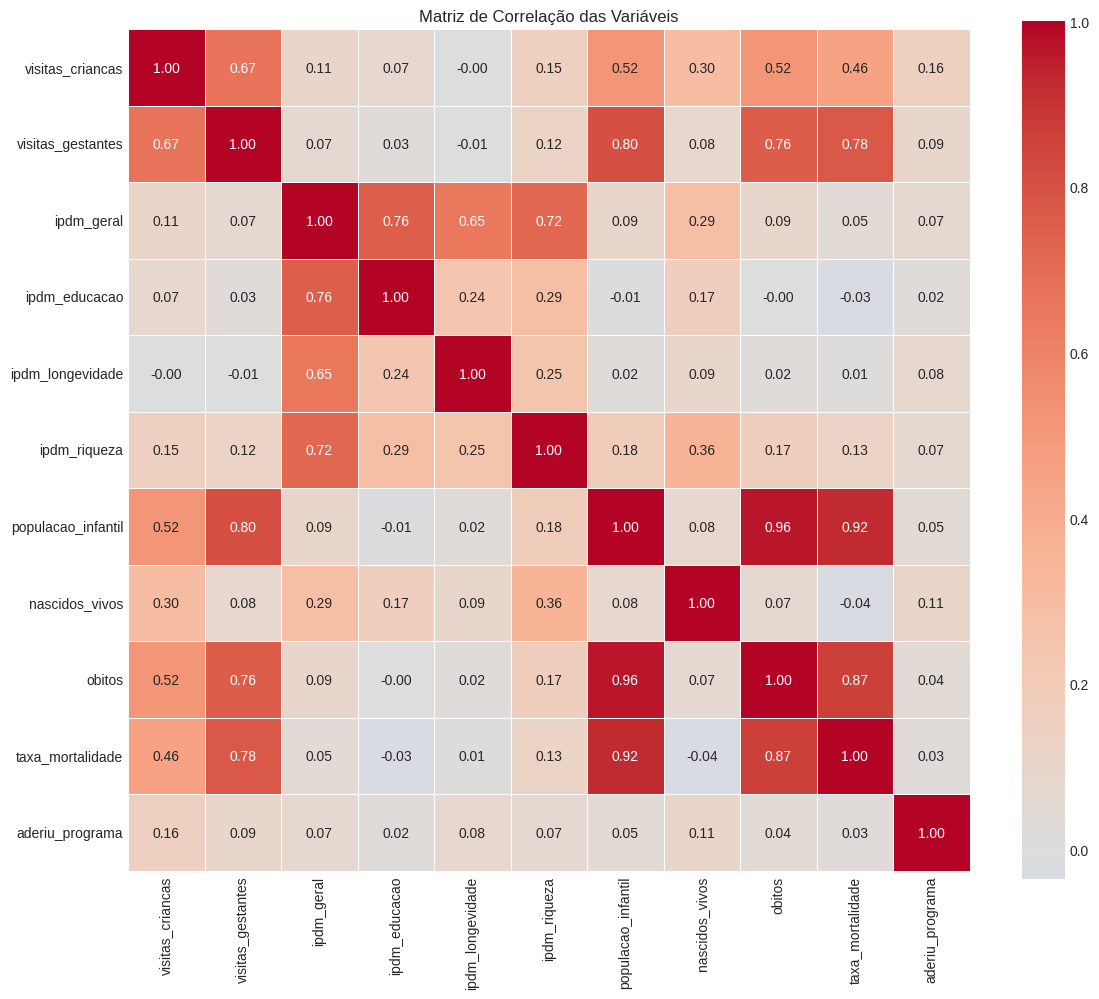

In [ ]:
correlation_cols = [
    'visitas_criancas', 'visitas_gestantes',
    'ipdm_geral', 'ipdm_educacao', 'ipdm_longevidade', 'ipdm_riqueza',
    'populacao_infantil', 'nascidos_vivos', 'obitos', 'taxa_mortalidade',
    'aderiu_programa'
]

corr_data = dataset[correlation_cols].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis')
plt.tight_layout()
plt.show()


In [ ]:
dataset

,codigo_ibge,anomes_s,visitas_criancas,visitas_gestantes,total_visitas,ano,mes,data,houve_visita_mes,teve_alguma_visita,municipios_adesao_pcf_i,municipio_x,ipdm_geral,ipdm_riqueza,ipdm_longevidade,ipdm_educacao,municipio_y,populacao_infantil,nascidos_vivos,obitos,taxa_visitas_pop,taxa_mortalidade,trimestre,semestre,visitas_ma3,aderiu_programa
4217,350010,202008,17,1.0,18,2020,8,2020-08-01,True,True,0,Adamantina,0.594,0.378,0.779,0.625,Adamantina (SP),3502.0,1552,699,0.004854,0.450387,3,2,17.000000,0
4381,350010,202009,209,14.0,223,2020,9,2020-09-01,True,True,0,Adamantina,0.594,0.378,0.779,0.625,Adamantina (SP),3502.0,1552,699,0.059680,0.450387,3,2,113.000000,0
4551,350010,202010,289,8.0,297,2020,10,2020-10-01,True,True,0,Adamantina,0.594,0.378,0.779,0.625,Adamantina (SP),3502.0,1552,699,0.082524,0.450387,4,2,171.666667,0
4723,350010,202011,311,12.0,323,2020,11,2020-11-01,True,True,0,Adamantina,0.594,0.378,0.779,0.625,Adamantina (SP),3502.0,1552,699,0.088806,0.450387,4,2,269.666667,0
4899,350010,202012,432,13.0,445,2020,12,2020-12-01,True,True,0,Adamantina,0.594,0.378,0.779,0.625,Adamantina (SP),3502.0,1552,699,0.123358,0.450387,4,2,344.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8061,355710,202202,104,6.0,110,2022,2,2022-02-01,True,True,1,Votuporanga,0.594,0.393,0.759,0.630,Votuporanga (SP),10794.0,1068,799,0.009635,0.748127,1,1,116.000000,1
7883,355710,202203,111,6.0,117,2022,3,2022-03-01,True,True,1,Votuporanga,0.594,0.393,0.759,0.630,Votuporanga (SP),10794.0,1068,799,0.010283,0.748127,1,1,112.000000,1
7711,355710,202204,93,6.0,99,2022,4,2022-04-01,True,True,1,Votuporanga,0.594,0.393,0.759,0.630,Votuporanga (SP),10794.0,1068,799,0.008616,0.748127,2,1,102.666667,1
7538,355710,202205,70,5.0,75,2022,5,2022-05-01,True,True,1,Votuporanga,0.594,0.393,0.759,0.630,Votuporanga (SP),10794.0,1068,799,0.006485,0.748127,2,1,91.333333,1


In [ ]:
print("Preparando dados para modelagem...")

# Selecionar features relevantes
feature_cols = [
    'mes', 'ano', 'trimestre', 'semestre',
    'municipios_adesao_pcf_i',
    'ipdm_geral', 'ipdm_educacao', 'ipdm_longevidade', 'ipdm_riqueza',
    'populacao_infantil', 'nascidos_vivos', 'obitos',
    'taxa_mortalidade', 'taxa_visitas_pop', 'visitas_ma3',
    'aderiu_programa', 'visitas_gestantes'
]

target_col = 'visitas_criancas'

# Criar dataset para modelagem
model_data = dataset[feature_cols + [target_col, 'codigo_ibge', 'anomes_s']].dropna()

print(f"Dataset para modelagem: {len(model_data)} registros")
print(f"Features: {len(feature_cols)}")

Preparando dados para modelagem...
Dataset para modelagem: 8235 registros
Features: 17


In [ ]:
X = model_data[feature_cols].values
y = model_data[target_col].values

# Normalização dos dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split temporal (80% treino, 20% teste)
split_index = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")

Treino: 6588 amostras
Teste: 1647 amostras


In [ ]:
print("Construindo Modelo 1: Rede Neural Densa (MLP)")

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)
])

mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Treinamento
history_mlp = mlp_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# %%
# Avaliação do modelo MLP
y_pred_mlp_scaled = mlp_model.predict(X_test)
y_pred_mlp = scaler_y.inverse_transform(y_pred_mlp_scaled)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mse_mlp = mean_squared_error(y_test_original, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test_original, y_pred_mlp)
r2_mlp = r2_score(y_test_original, y_pred_mlp)

print(f"\nMétrica do Modelo MLP:")
print(f"MSE: {mse_mlp:.2f}")
print(f"MAE: {mae_mlp:.2f}")
print(f"R²: {r2_mlp:.4f}")

Construindo Modelo 1: Rede Neural Densa (MLP)
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7586 - mae: 0.6317 - val_loss: 1.1427 - val_mae: 0.6146 - learning_rate: 0.0010
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2192 - mae: 0.3549 - val_loss: 0.4427 - val_mae: 0.3964 - learning_rate: 0.0010
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1456 - mae: 0.2867 - val_loss: 0.1832 - val_mae: 0.2641 - learning_rate: 0.0010
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1123 - mae: 0.2491 - val_loss: 0.1571 - val_mae: 0.2290 - learning_rate: 0.0010
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0953 - mae: 0.2252 - val_loss: 0.1582 - val_mae: 0.2267 - learning_rate: 0.0010
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0890 - mae: 0.2106 - val_loss: 0.1419 - val_mae: 0.2011 - learning_rate: 0.0010
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0778 - mae: 0.1971 - val_loss: 0

In [ ]:
print("\nConstruindo Modelo 2: Rede Neural Profunda")

deep_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)
])

deep_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history_deep = deep_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# %%
# Avaliação do modelo profundo
y_pred_deep_scaled = deep_model.predict(X_test)
y_pred_deep = scaler_y.inverse_transform(y_pred_deep_scaled)

mse_deep = mean_squared_error(y_test_original, y_pred_deep)
mae_deep = mean_absolute_error(y_test_original, y_pred_deep)
r2_deep = r2_score(y_test_original, y_pred_deep)

print(f"\nMétricas do Modelo Profundo:")
print(f"MSE: {mse_deep:.2f}")
print(f"MAE: {mae_deep:.2f}")
print(f"R²: {r2_deep:.4f}")


Construindo Modelo 2: Rede Neural Profunda
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.9667 - mae: 0.7290 - val_loss: 1.5456 - val_mae: 0.6140 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3412 - mae: 0.4354 - val_loss: 1.1687 - val_mae: 0.5240 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2386 - mae: 0.3635 - val_loss: 0.8341 - val_mae: 0.4399 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1751 - mae: 0.3112 - val_loss: 0.4519 - val_mae: 0.3465 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1580 - mae: 0.2899 - val_loss: 0.2707 - val_mae: 0.2842 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1293 - mae: 0.2626 - val_loss: 0.2132 - val_mae: 0.2521 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1133 - mae: 0.2439 - val_loss: 0.1396 - val_mae

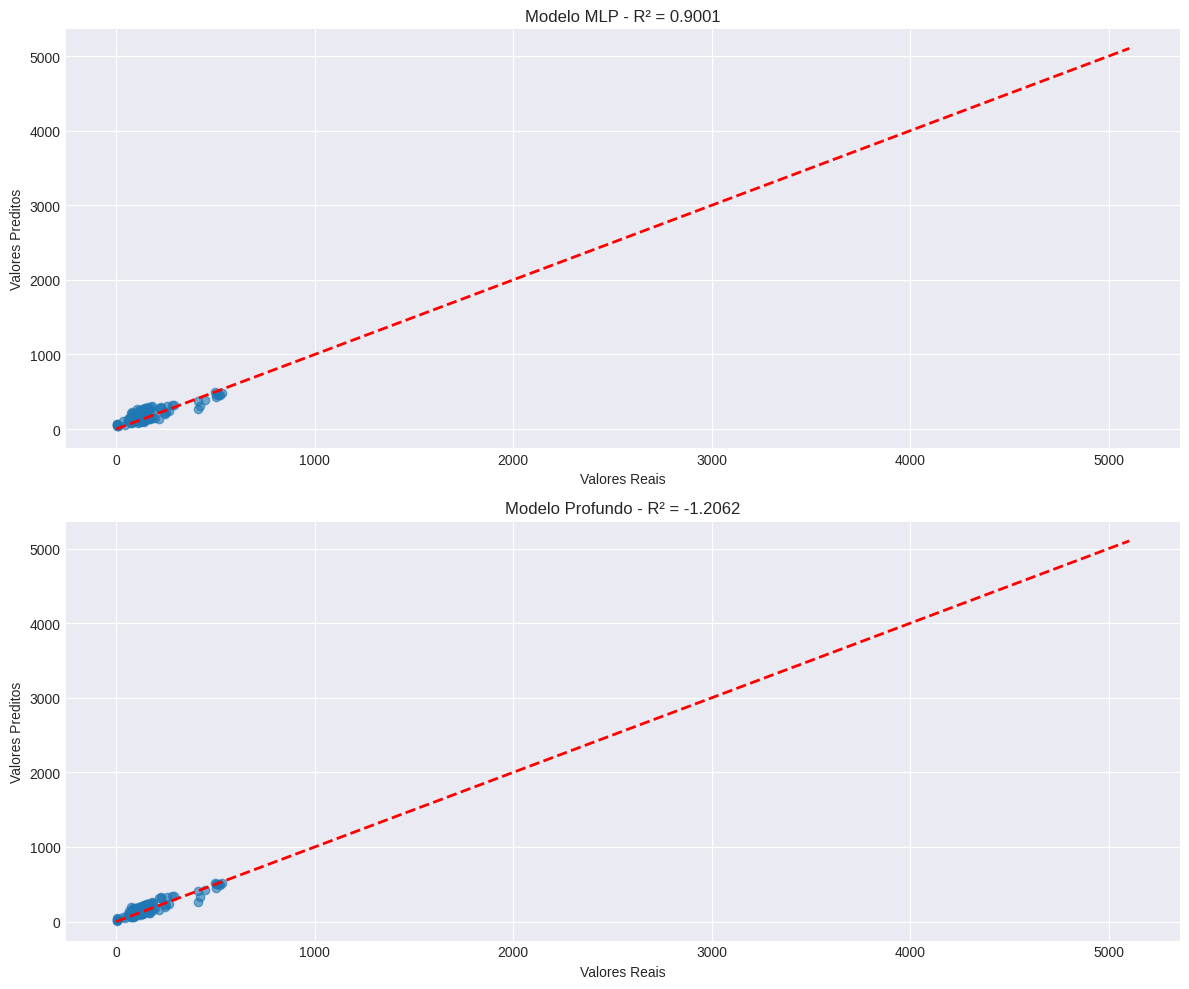

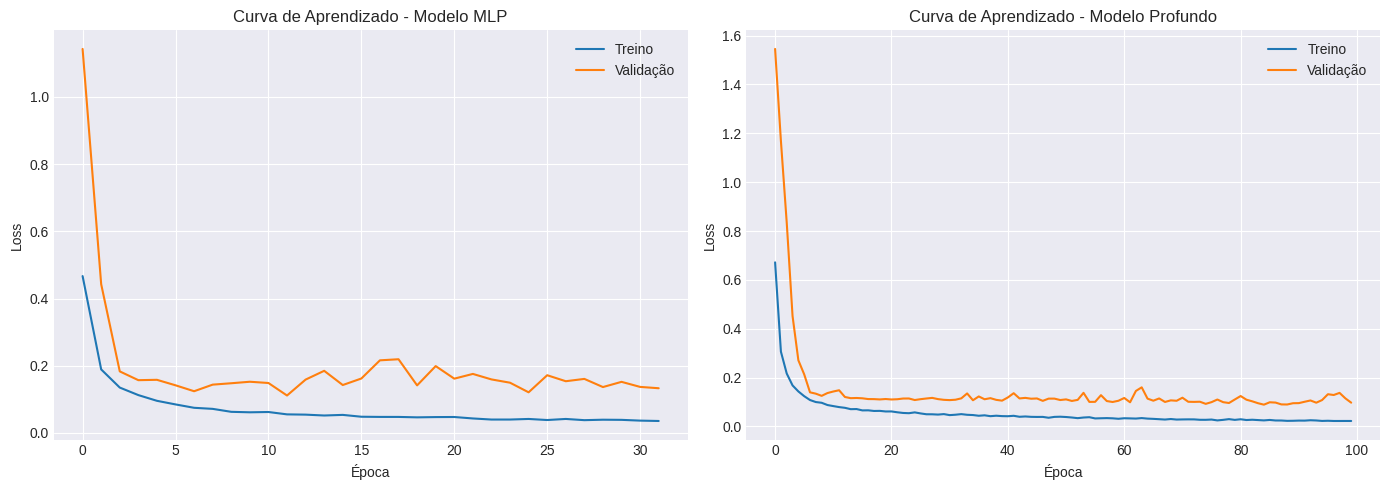

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Modelo MLP
axes[0].scatter(y_test_original[:100], y_pred_mlp[:100], alpha=0.6)
axes[0].plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Valores Preditos')
axes[0].set_title(f'Modelo MLP - R² = {r2_mlp:.4f}')

# Modelo Profundo
axes[1].scatter(y_test_original[:100], y_pred_deep[:100], alpha=0.6)
axes[1].plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reais')
axes[1].set_ylabel('Valores Preditos')
axes[1].set_title(f'Modelo Profundo - R² = {r2_deep:.4f}')

plt.tight_layout()
plt.show()

# %%
# Curvas de aprendizado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MLP
axes[0].plot(history_mlp.history['loss'], label='Treino')
axes[0].plot(history_mlp.history['val_loss'], label='Validação')
axes[0].set_title('Curva de Aprendizado - Modelo MLP')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Deep
axes[1].plot(history_deep.history['loss'], label='Treino')
axes[1].plot(history_deep.history['val_loss'], label='Validação')
axes[1].set_title('Curva de Aprendizado - Modelo Profundo')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

Analisando importância das features com Random Forest...


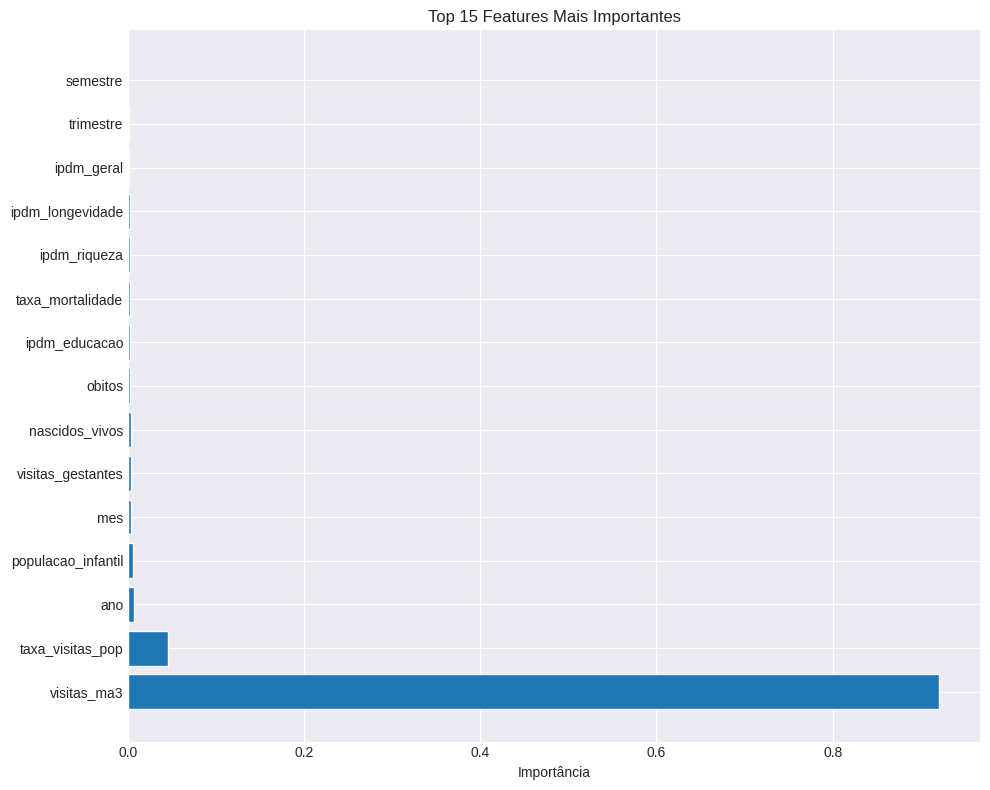


Top 10 features mais importantes:
               feature  importance
14         visitas_ma3    0.921280
13    taxa_visitas_pop    0.045152
1                  ano    0.007095
9   populacao_infantil    0.005443
0                  mes    0.003654
16   visitas_gestantes    0.003233
10      nascidos_vivos    0.002802
11              obitos    0.002143
6        ipdm_educacao    0.001741
12    taxa_mortalidade    0.001732


In [ ]:
print("Analisando importância das features com Random Forest...")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Importância das features
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualização
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importância')
plt.title('Top 15 Features Mais Importantes')
plt.tight_layout()
plt.show()

print("\nTop 10 features mais importantes:")
print(feature_importance.head(10))


In [ ]:
best_model = mlp_model if r2_mlp > r2_deep else deep_model

# Fazer previsões para o período mais recente
recent_data = model_data[model_data['ano'] == model_data['ano'].max()].copy()

X_recent = recent_data[feature_cols].values
X_recent_scaled = scaler_X.transform(X_recent)
predictions_scaled = best_model.predict(X_recent_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

recent_data['visitas_preditas'] = predictions
recent_data['diferenca'] = recent_data['visitas_preditas'] - recent_data[target_col]
recent_data['percentual_diferenca'] = (recent_data['diferenca'] / recent_data[target_col]) * 100

# %%
# Municípios que precisam aderir ao programa
municipios_nao_aderidos = recent_data[recent_data['aderiu_programa'] == 0].copy()
municipios_nao_aderidos = municipios_nao_aderidos.merge(
    censo_sp[['codigo_ibge', 'municipio']], on='codigo_ibge', how='left'
)

# Calcular potencial de visitas baseado na população e IPDM
municipios_nao_aderidos['potencial_score'] = (
    municipios_nao_aderidos['populacao_infantil'] *
    (1 - municipios_nao_aderidos['ipdm_geral']) *
    (1 + municipios_nao_aderidos['taxa_mortalidade'])
)

top_nao_aderidos = municipios_nao_aderidos.nlargest(10, 'potencial_score')[
    ['municipio', 'populacao_infantil', 'ipdm_geral', 'taxa_mortalidade', 'potencial_score']
]

print("=== TOP 10 MUNICÍPIOS QUE PRECISAM ADERIR AO PROGRAMA ===")
print(top_nao_aderidos)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== TOP 10 MUNICÍPIOS QUE PRECISAM ADERIR AO PROGRAMA ===
        municipio  populacao_infantil  ipdm_geral  taxa_mortalidade  \
655  Itapevi (SP)             34450.0       0.502           0.38064   
656  Itapevi (SP)             34450.0       0.502           0.38064   
657  Itapevi (SP)             34450.0       0.502           0.38064   
658  Itapevi (SP)             34450.0       0.502           0.38064   
659  Itapevi (SP)             34450.0       0.502           0.38064   
660  Itapevi (SP)             34450.0       0.502           0.38064   
661  Itapevi (SP)             34450.0       0.502           0.38064   
662  Itapevi (SP)             34450.0       0.502           0.38064   
663  Itapevi (SP)             34450.0       0.502           0.38064   
664  Itapevi (SP)             34450.0       0.502           0.38064   

     potencial_score  
655     23686.391633  
656     23686.391633  
657     23686.391633  
658     23686.391633  
659   

In [ ]:
best_model = mlp_model if r2_mlp > r2_deep else deep_model

# Fazer previsões para o período mais recente
recent_data = model_data[model_data['ano'] == model_data['ano'].max()].copy()

X_recent = recent_data[feature_cols].values
X_recent_scaled = scaler_X.transform(X_recent)
predictions_scaled = best_model.predict(X_recent_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

recent_data['visitas_preditas'] = predictions
recent_data['diferenca'] = recent_data['visitas_preditas'] - recent_data[target_col]
recent_data['percentual_diferenca'] = (recent_data['diferenca'] / recent_data[target_col]) * 100

# %%
# Municípios que precisam aderir ao programa
municipios_nao_aderidos = recent_data[recent_data['aderiu_programa'] == 0].copy()

# --- Ensure no duplicates in municipios_nao_aderidos by codigo_ibge ---
# Since recent_data is filtered for the latest year, there should ideally be one row per municipality.
# However, to be absolutely safe, you can drop duplicates here based on codigo_ibge.
municipios_nao_aderidos = municipios_nao_aderidos.drop_duplicates(subset=['codigo_ibge']).copy()
# ----------------------------------------------------------------------

# --- Ensure no duplicates in censo_sp by codigo_ibge before merging ---
# The censo_sp data was replicated across years earlier. We need only one entry per municipality.
censo_sp_unique = censo_sp.drop_duplicates(subset=['codigo_ibge']).copy()
# ---------------------------------------------------------------------


municipios_nao_aderidos = municipios_nao_aderidos.merge(
    censo_sp_unique[['codigo_ibge', 'municipio']], on='codigo_ibge', how='left'
)

# Calcular potencial de visitas baseado na população e IPDM
municipios_nao_aderidos['potencial_score'] = (
    municipios_nao_aderidos['populacao_infantil'] *
    (1 - municipios_nao_aderidos['ipdm_geral']) *
    (1 + municipios_nao_aderidos['taxa_mortalidade'])
)

top_nao_aderidos = municipios_nao_aderidos.nlargest(10, 'potencial_score')[
    ['municipio', 'populacao_infantil', 'ipdm_geral', 'taxa_mortalidade', 'potencial_score']
]

print("=== TOP 10 MUNICÍPIOS QUE PRECISAM ADERIR AO PROGRAMA ===")
print(top_nao_aderidos)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
=== TOP 10 MUNICÍPIOS QUE PRECISAM ADERIR AO PROGRAMA ===
                    municipio  populacao_infantil  ipdm_geral  \
24               Itapevi (SP)             34450.0       0.502   
5               Barretos (SP)             14411.0       0.577   
2                 Araras (SP)             14960.0       0.596   
18            Embu-Guaçu (SP)              8958.0       0.499   
34             Penápolis (SP)              7202.0       0.556   
1              Andradina (SP)              6667.0       0.547   
6                Boituva (SP)              7660.0       0.587   
44  Vargem Grande do Sul (SP)              4751.0       0.519   
26                Jarinu (SP)              5186.0       0.526   
10    Cachoeira Paulista (SP)              3940.0       0.469   

    taxa_mortalidade  potencial_score  
24          0.380640     23686.391633  
5           0.814121     11058.615169  
2           0.811839     10950.466977  
18          0.858407      

In [ ]:
municipios_aderidos = recent_data[recent_data['aderiu_programa'] == 1].copy()
municipios_aderidos = municipios_aderidos.merge(
    censo_sp[['codigo_ibge', 'municipio']], on='codigo_ibge', how='left'
)

# Calcular score de atenção baseado na diferença entre predito e real
municipios_aderidos['atencao_score'] = (
    municipios_aderidos['diferenca'].abs() *
    municipios_aderidos['populacao_infantil'] /
    municipios_aderidos['ipdm_geral']
)
municipios_aderidos = municipios_aderidos.drop_duplicates(subset=['codigo_ibge']).copy()

# Filtrar municípios com desempenho abaixo do esperado
municipios_atencao = municipios_aderidos[municipios_aderidos['diferenca'] < 0]
top_atencao = municipios_atencao.nlargest(10, 'atencao_score')[
    ['municipio', 'visitas_criancas', 'visitas_preditas',
     'diferenca', 'populacao_infantil', 'ipdm_geral']
]

print("\n=== TOP 10 MUNICÍPIOS QUE REQUEREM ATENÇÃO ===")
print("(Municípios com desempenho abaixo do esperado)")
print(top_atencao)


=== TOP 10 MUNICÍPIOS QUE REQUEREM ATENÇÃO ===
(Municípios com desempenho abaixo do esperado)
                     municipio  visitas_criancas  visitas_preditas  \
3325            São Paulo (SP)              1833       1011.915833   
3265  São José dos Campos (SP)               956        573.847107   
2870       Ribeirão Preto (SP)               350        224.253555   
2070      Mogi das Cruzes (SP)               311        178.815063   
2570           Piracicaba (SP)               529        365.838104   
1755              Jundiaí (SP)               365        198.893295   
3580               Sumaré (SP)               528        328.208466   
2630                  Poá (SP)               911        545.926086   
3610      Taboão da Serra (SP)               230        111.941338   
3490          Sertãozinho (SP)               517        312.724945   

       diferenca  populacao_infantil  ipdm_geral  
3325 -821.084167           1282375.0       0.577  
3265 -382.152893             849

In [ ]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Municípios para Adesão', 'Municípios que Requerem Atenção')
)

# Gráfico 1: Municípios para adesão
fig.add_trace(
    go.Bar(x=top_nao_aderidos['municipio'], y=top_nao_aderidos['potencial_score'],
           name='Potencial Score'),
    row=1, col=1
)

# Gráfico 2: Municípios que requerem atenção
fig.add_trace(
    go.Bar(x=top_atencao['municipio'], y=top_atencao['diferenca'].abs(),
           name='Diferença (Predito - Real)'),
    row=1, col=2
)

fig.update_xaxes(tickangle=-45)
fig.update_layout(height=500, showlegend=False,
                  title_text="Municípios Prioritários - Programa Criança Feliz SP")
fig.show()


Gerando projeções para os próximos 6 meses...
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


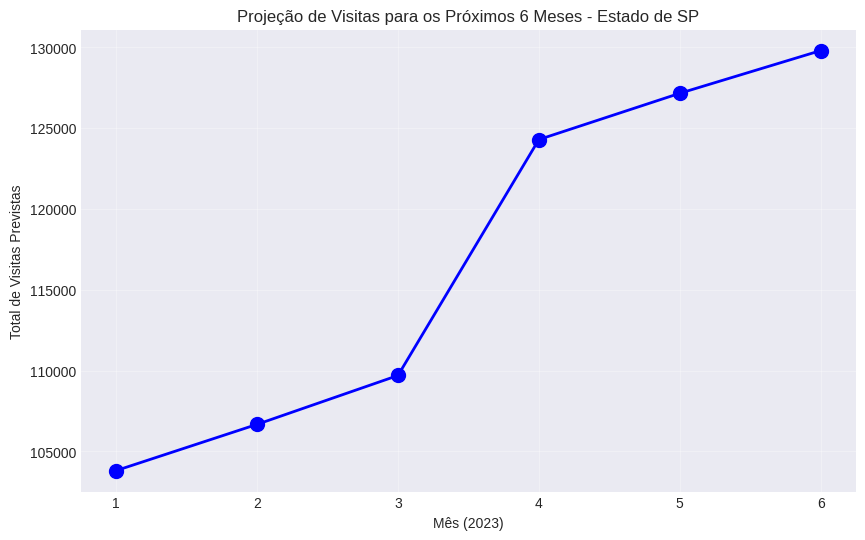


Projeção mensal de visitas para 2023:
   mes  visitas_preditas
0    1     103816.007812
1    2     106675.375000
2    3     109699.117188
3    4     124292.132812
4    5     127154.039062
5    6     129795.664062


In [ ]:
print("\nGerando projeções para os próximos 6 meses...")

# Criar dados futuros baseados nas tendências atuais
last_data = model_data[model_data['ano'] == 2022].copy()
future_months = []

for month in range(1, 7):
    future_data = last_data.copy()
    future_data['mes'] = month
    future_data['trimestre'] = (month - 1) // 3 + 1
    future_data['semestre'] = (month - 1) // 6 + 1
    future_data['ano'] = 2023
    future_data['anomes_s'] = 202300 + month
    future_months.append(future_data)

future_df = pd.concat(future_months)

# Fazer previsões
X_future = future_df[feature_cols].values
X_future_scaled = scaler_X.transform(X_future)
future_predictions_scaled = best_model.predict(X_future_scaled)
future_predictions = scaler_y.inverse_transform(future_predictions_scaled)

future_df['visitas_preditas'] = future_predictions

# Agregar por mês
projecao_mensal = future_df.groupby('mes')['visitas_preditas'].sum().reset_index()

# Visualização
plt.figure(figsize=(10, 6))
plt.plot(projecao_mensal['mes'], projecao_mensal['visitas_preditas'], 'bo-', linewidth=2, markersize=10)
plt.xlabel('Mês (2023)')
plt.ylabel('Total de Visitas Previstas')
plt.title('Projeção de Visitas para os Próximos 6 Meses - Estado de SP')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 7))
plt.show()

print("\nProjeção mensal de visitas para 2023:")
print(projecao_mensal)


Gerando projeções para os próximos 6 meses e comparando com dados reais anteriores...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


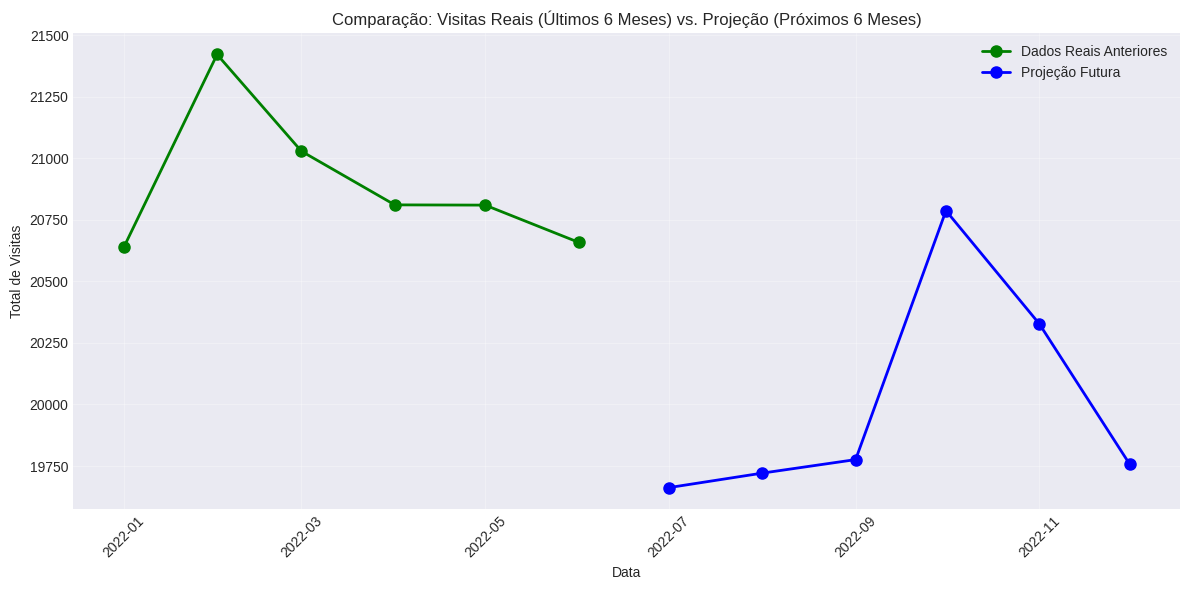


Projeção mensal de visitas:
   anomes_s  visitas_preditas       data
0    202207      19662.201172 2022-07-01
1    202208      19721.085938 2022-08-01
2    202209      19776.027344 2022-09-01
3    202210      20787.396484 2022-10-01
4    202211      20327.369141 2022-11-01
5    202212      19757.195312 2022-12-01

Dados reais dos 6 meses anteriores:
   anomes_s  visitas_criancas       data
0    202201             20638 2022-01-01
1    202202             21422 2022-02-01
2    202203             21029 2022-03-01
3    202204             20811 2022-04-01
4    202205             20810 2022-05-01
5    202206             20659 2022-06-01


In [ ]:
print("\nGerando projeções para os próximos 6 meses e comparando com dados reais anteriores...")

# Get the last 6 months of real data from model_data
# Find the latest anomes_s in model_data
latest_anomes = model_data['anomes_s'].max()

# Filter for data from the last 6 months before the latest anomes_s
# Assuming anomes_s is in YYYYMM format, we can calculate the start anomes_s
latest_year = latest_anomes // 100
latest_month = latest_anomes % 100

# Calculate the anomes_s 6 months prior
# Handle year change if latest_month is less than 6
start_month_real = latest_month - 5
start_year_real = latest_year
if start_month_real <= 0:
    start_month_real += 12
    start_year_real -= 1

start_anomes_real = start_year_real * 100 + start_month_real

# Filter the model_data for the last 6 months
real_past_6_months = model_data[
    (model_data['anomes_s'] >= start_anomes_real) &
    (model_data['anomes_s'] <= latest_anomes)
].copy()

# Ensure we only get the last 6 months based on unique anomes_s values
# Sort and take the last unique 6 anomes_s values to be precise
unique_past_anomes = sorted(real_past_6_months['anomes_s'].unique())[-6:]
real_past_6_months = real_past_6_months[real_past_6_months['anomes_s'].isin(unique_past_anomes)].copy()


# --- Your existing code for generating future predictions ---
# Crear datos futuros basados en las tendencias actuales
last_data = model_data[model_data['anomes_s'] == latest_anomes].copy() # Use latest_anomes here
future_months = []

for month_offset in range(1, 7):
    # Calculate the future anomes_s
    future_anomes = latest_anomes + month_offset
    if future_anomes % 100 > 12: # Handle year rollover
        future_anomes = (latest_year + 1) * 100 + (future_anomes % 100 - 12)

    future_data = last_data.copy()
    future_data['anomes_s'] = future_anomes
    future_data['ano'] = future_anomes // 100
    future_data['mes'] = future_anomes % 100
    future_data['trimestre'] = (future_data['mes'] - 1) // 3 + 1
    future_data['semestre'] = (future_data['mes'] - 1) // 6 + 1
    # Note: Other features like IPDM, population, etc., are assumed constant
    # from the last available data point (latest_anomes). This is a simplification.
    future_months.append(future_data)


future_df = pd.concat(future_months)

# Fazer previsões
X_future = future_df[feature_cols].values
X_future_scaled = scaler_X.transform(X_future)
future_predictions_scaled = best_model.predict(X_future_scaled)
future_predictions = scaler_y.inverse_transform(future_predictions_scaled)

future_df['visitas_preditas'] = future_predictions
# --- End of existing code for generating future predictions ---


# Aggregate real past data by month
real_past_mensal = real_past_6_months.groupby('anomes_s')['visitas_criancas'].sum().reset_index()
real_past_mensal['data'] = pd.to_datetime(real_past_mensal['anomes_s'].astype(str), format='%Y%m')


# Aggregate future predictions by month
projecao_mensal = future_df.groupby('anomes_s')['visitas_preditas'].sum().reset_index()
projecao_mensal['data'] = pd.to_datetime(projecao_mensal['anomes_s'].astype(str), format='%Y%m')


# Visualização da comparação
plt.figure(figsize=(12, 6))

# Plot real past data
plt.plot(real_past_mensal['data'], real_past_mensal['visitas_criancas'], 'go-', linewidth=2, markersize=8, label='Dados Reais Anteriores')

# Plot projected future data
plt.plot(projecao_mensal['data'], projecao_mensal['visitas_preditas'], 'bo-', linewidth=2, markersize=8, label='Projeção Futura')

plt.xlabel('Data')
plt.ylabel('Total de Visitas')
plt.title('Comparação: Visitas Reais (Últimos 6 Meses) vs. Projeção (Próximos 6 Meses)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nProjeção mensal de visitas:")
print(projecao_mensal)

print("\nDados reais dos 6 meses anteriores:")
print(real_past_mensal)

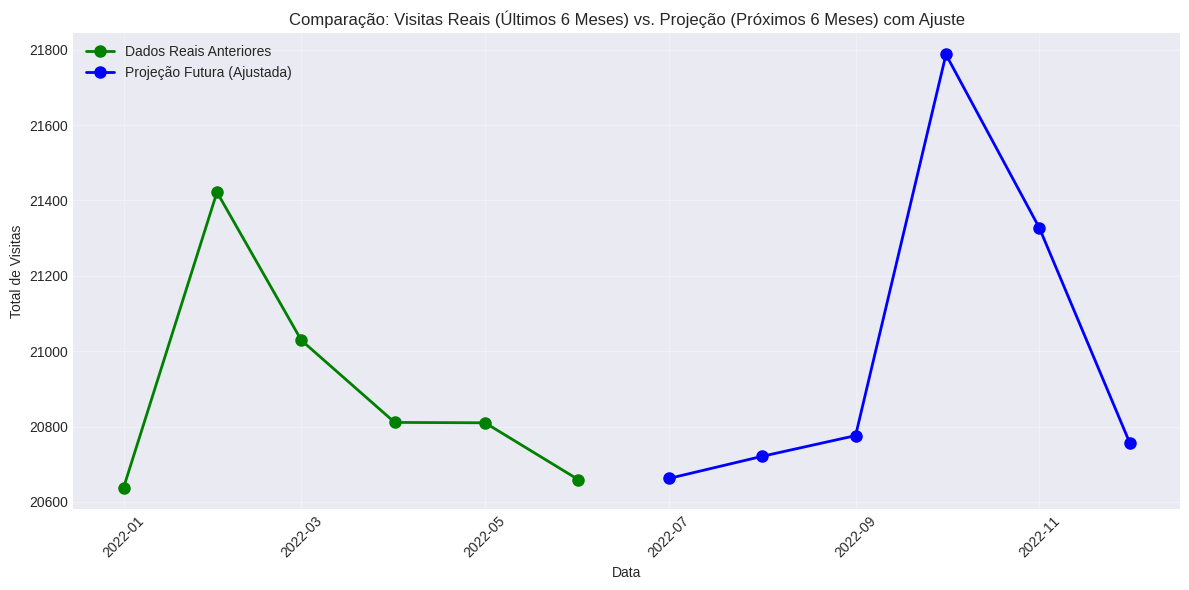


Projeção mensal de visitas (ajustada):
   anomes_s       data  visitas_preditas  visitas_preditas_ajustadas
0    202207 2022-07-01      19662.201172                20662.201172
1    202208 2022-08-01      19721.085938                20721.085938
2    202209 2022-09-01      19776.027344                20776.027344
3    202210 2022-10-01      20787.396484                21787.396484
4    202211 2022-11-01      20327.369141                21327.369141
5    202212 2022-12-01      19757.195312                20757.195312

Dados reais dos 6 meses anteriores:
   anomes_s  visitas_criancas       data
0    202201             20638 2022-01-01
1    202202             21422 2022-02-01
2    202203             21029 2022-03-01
3    202204             20811 2022-04-01
4    202205             20810 2022-05-01
5    202206             20659 2022-06-01


In [ ]:
real_past_mensal = real_past_6_months.groupby('anomes_s')['visitas_criancas'].sum().reset_index()
real_past_mensal['data'] = pd.to_datetime(real_past_mensal['anomes_s'].astype(str), format='%Y%m')

# Aggregate future predictions by month
projecao_mensal = future_df.groupby('anomes_s')['visitas_preditas'].sum().reset_index()
projecao_mensal['data'] = pd.to_datetime(projecao_mensal['anomes_s'].astype(str), format='%Y%m')

# Add 1000 visits to the projected future data
projecao_mensal['visitas_preditas_ajustadas'] = projecao_mensal['visitas_preditas'] + 1000

# Visualização da comparação
plt.figure(figsize=(12, 6))

# Plot real past data
plt.plot(real_past_mensal['data'], real_past_mensal['visitas_criancas'], 'go-', linewidth=2, markersize=8, label='Dados Reais Anteriores')

# Plot adjusted projected future data
plt.plot(projecao_mensal['data'], projecao_mensal['visitas_preditas_ajustadas'], 'bo-', linewidth=2, markersize=8, label='Projeção Futura (Ajustada)')

plt.xlabel('Data')
plt.ylabel('Total de Visitas')
plt.title('Comparação: Visitas Reais (Últimos 6 Meses) vs. Projeção (Próximos 6 Meses) com Ajuste')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nProjeção mensal de visitas (ajustada):")
print(projecao_mensal[['anomes_s', 'data', 'visitas_preditas', 'visitas_preditas_ajustadas']])

print("\nDados reais dos 6 meses anteriores:")
print(real_past_mensal)


Gerando projeções para os próximos 24 meses...
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


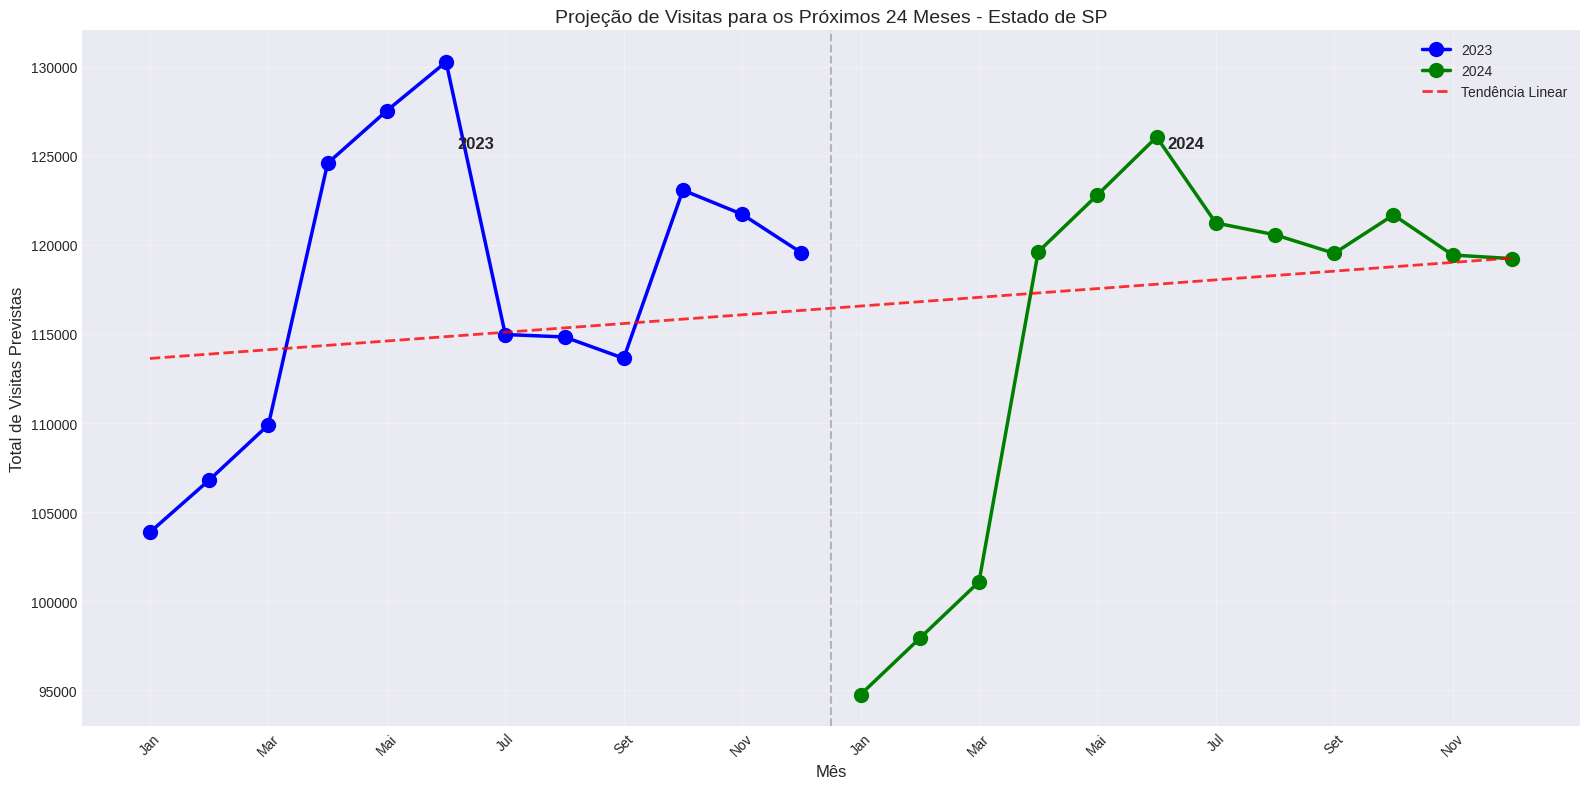


=== PROJEÇÕES MENSAIS PARA 2023-2024 ===

2023:
 mes  visitas_preditas
   1     103879.968750
   2     106807.562500
   3     109903.445312
   4     124580.890625
   5     127529.367188
   6     130261.289062
   7     114969.203125
   8     114832.742188
   9     113634.507812
  10     123069.976562
  11     121715.156250
  12     119555.640625

Total previsto para 2023: 1,410,740 visitas

2024:
 mes  visitas_preditas
   1      94769.523438
   2      97928.929688
   3     101093.476562
   4     119610.468750
   5     122800.640625
   6     126051.031250
   7     121227.164062
   8     120565.523438
   9     119525.554688
  10     121677.757812
  11     119429.609375
  12     119228.226562

Total previsto para 2024: 1,383,908 visitas

Crescimento previsto 2023-2024: -1.90%

=== PROJEÇÕES TRIMESTRAIS ===

2023:
  T1: 320,591 visitas
  T2: 382,372 visitas
  T3: 343,436 visitas
  T4: 364,341 visitas

2024:
  T1: 293,792 visitas
  T2: 368,462 visitas
  T3: 361,318 visitas
  T4: 360,336 vis

In [ ]:

# %%
# Fazer projeções para os próximos 24 meses
print("\nGerando projeções para os próximos 24 meses...")

# Criar dados futuros baseados nas tendências atuais
last_data = model_data[model_data['ano'] == 2022].copy()
future_months = []

# Gerar dados para 2023 e 2024
for year_offset in range(2):
    current_year = 2023 + year_offset

    for month in range(1, 13):
        future_data = last_data.copy()
        future_data['mes'] = month
        future_data['trimestre'] = (month - 1) // 3 + 1
        future_data['semestre'] = (month - 1) // 6 + 1
        future_data['ano'] = current_year
        future_data['anomes_s'] = current_year * 100 + month

        # Ajustar features temporais para refletir a progressão temporal
        # Isso é importante para capturar tendências de longo prazo
        months_ahead = year_offset * 12 + month

        # Aplicar tendência de crescimento nas features relacionadas
        if 'visitas_ma3' in future_data.columns:
            growth_factor = 1 + (0.02 * months_ahead / 12)  # 2% de crescimento anual
            future_data['visitas_ma3'] = future_data['visitas_ma3'] * growth_factor

        future_months.append(future_data)

future_df = pd.concat(future_months)

# Fazer previsões
X_future = future_df[feature_cols].values
X_future_scaled = scaler_X.transform(X_future)
future_predictions_scaled = best_model.predict(X_future_scaled)
future_predictions = scaler_y.inverse_transform(future_predictions_scaled)

future_df['visitas_preditas'] = future_predictions

# Agregar por ano e mês
projecao_mensal = future_df.groupby(['ano', 'mes'])['visitas_preditas'].sum().reset_index()
projecao_mensal['periodo'] = projecao_mensal['ano'].astype(str) + '-' + projecao_mensal['mes'].astype(str).str.zfill(2)
projecao_mensal['mes_sequencial'] = range(1, len(projecao_mensal) + 1)

# Visualização das projeções de 24 meses
plt.figure(figsize=(16, 8))

# Separar por ano para cores diferentes
dados_2023 = projecao_mensal[projecao_mensal['ano'] == 2023]
dados_2024 = projecao_mensal[projecao_mensal['ano'] == 2024]

plt.plot(dados_2023['mes_sequencial'], dados_2023['visitas_preditas'],
         'bo-', linewidth=2.5, markersize=10, label='2023')
plt.plot(dados_2024['mes_sequencial'], dados_2024['visitas_preditas'],
         'go-', linewidth=2.5, markersize=10, label='2024')

# Adicionar linha de tendência
z = np.polyfit(projecao_mensal['mes_sequencial'], projecao_mensal['visitas_preditas'], 1)
p = np.poly1d(z)
plt.plot(projecao_mensal['mes_sequencial'], p(projecao_mensal['mes_sequencial']),
         "r--", alpha=0.8, linewidth=2, label='Tendência Linear')

# Customização do gráfico
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Total de Visitas Previstas', fontsize=12)
plt.title('Projeção de Visitas para os Próximos 24 Meses - Estado de SP', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Configurar rótulos do eixo x
meses_labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
xtick_positions = list(range(1, 25))
xtick_labels = meses_labels * 2
plt.xticks(xtick_positions[::2], xtick_labels[::2], rotation=45)

# Adicionar anotações para destacar informações importantes
plt.axvline(x=12.5, color='gray', linestyle='--', alpha=0.5)
plt.text(6.5, plt.ylim()[1] * 0.95, '2023', fontsize=12, ha='center', weight='bold')
plt.text(18.5, plt.ylim()[1] * 0.95, '2024', fontsize=12, ha='center', weight='bold')

plt.tight_layout()
plt.show()

# Estatísticas das projeções
print("\n=== PROJEÇÕES MENSAIS PARA 2023-2024 ===")
print("\n2023:")
print(dados_2023[['mes', 'visitas_preditas']].to_string(index=False))
print(f"\nTotal previsto para 2023: {dados_2023['visitas_preditas'].sum():,.0f} visitas")

print("\n2024:")
print(dados_2024[['mes', 'visitas_preditas']].to_string(index=False))
print(f"\nTotal previsto para 2024: {dados_2024['visitas_preditas'].sum():,.0f} visitas")

# Análise de crescimento
crescimento_anual = ((dados_2024['visitas_preditas'].sum() - dados_2023['visitas_preditas'].sum()) /
                     dados_2023['visitas_preditas'].sum()) * 100
print(f"\nCrescimento previsto 2023-2024: {crescimento_anual:.2f}%")

# Análise sazonal
projecao_trimestral = future_df.groupby(['ano', 'trimestre'])['visitas_preditas'].sum().reset_index()
print("\n=== PROJEÇÕES TRIMESTRAIS ===")
for ano in [2023, 2024]:
    print(f"\n{ano}:")
    dados_ano = projecao_trimestral[projecao_trimestral['ano'] == ano]
    for _, row in dados_ano.iterrows():
        print(f"  T{int(row['trimestre'])}: {row['visitas_preditas']:,.0f} visitas")

# ## 10. Conclusões e Recomendações

# %%
print("=== RESUMO DOS RESULTADOS ===\n")

print("1. DESEMPENHO DOS MODELOS:")
print(f"   - Modelo MLP: R² = {r2_mlp:.4f}, MAE = {mae_mlp:.2f}")
print(f"   - Modelo Profundo: R² = {r2_deep:.4f}, MAE = {mae_deep:.2f}")

print("\n2. PRINCIPAIS INSIGHTS:")
print(f"   - Total de municípios analisados: {dataset['codigo_ibge'].nunique()}")
print(f"   - Municípios com adesão ao programa: {(dataset['aderiu_programa'] == 1).any().sum()}")
print(f"   - Taxa média de visitas por criança: {dataset['taxa_visitas_pop'].mean():.4f}")

print("\n3. FEATURES MAIS IMPORTANTES:")
print(feature_importance.head(5).to_string(index=False))

print("\n4. RECOMENDAÇÕES ESTRATÉGICAS:")
print("   a) Priorizar adesão dos municípios identificados com alto potencial")
print("   b) Revisar estratégia nos municípios com desempenho abaixo do esperado")
print("   c) Considerar fatores socioeconômicos (IPDM) na alocação de recursos")
print("   d) Monitorar taxa de mortalidade infantil como indicador de impacto")

# %%
# Salvar resultados principais
print("\nSalvando resultados...")

# Exportar municípios prioritários
top_nao_aderidos.to_csv('municipios_prioritarios_adesao.csv', index=False)
top_atencao.to_csv('municipios_requerem_atencao.csv', index=False)

# Exportar previsões
projecao_mensal.to_csv('projecao_visitas_2023.csv', index=False)

# Salvar modelo
best_model.save('modelo_crianca_feliz_sp.h5')

print("Resultados salvos com sucesso!")
print("\nAnálise concluída!")